#### Introduction

Airbnb, globally recognized as a groundbreaking platform for hosting and experiences, is a gold mine of data, unveiling patterns and insights about the dynamic short-term rental market. London, ranking as the third most visited city in the world according to [Wikipedia](https://en.wikipedia.org/wiki/List_of_cities_by_international_visitors), offers a rich diversity of such data. Having a personal connection to the city, having lived there for six months, I'm particularly excited to delve into this data. Through this analysis, I aspire to uncover trends and patterns that will not only deepen our understanding of the rental market in London but also reveal findings with significant commercial value.

For this analytical journey, I will be using the dataset from September 6, 2023, available at [Inside Airbnb](http://insideairbnb.com/get-the-data/), specifically focused on London, UK. My goal is to address and answer 10 critical questions, ensuring that each derived insight is of high value, accurate, and innovative. I will be conducting this analysis with complete transparency, elucidating the rationale that moves from question formulation to conclusion. It's vital to note that both positive and negative outcomes will be valuable, as long as they are substantiated and justified.


<div align="center">
    <img src="imgs/inside_airbnb_london.png" width="450">
</div>


It's worth mentioning that while seeking information about the database, I came across the following article which states that it is possible to find errors in the analyzed dataset. I have not found any works indicating that these issues have been resolved, as the article is from 2020. Due to time constraints (I only have 24 hours to complete the proposed work), I will assume that the dataset is accurate. (Link to the article: https://www.sciencedirect.com/science/article/abs/pii/S0167923620302086)

Below are some quotations from the article:


> "For example, Fig. 2 shows five reviews linked to a listing with the listing ID “344.” The first and third reviews were both present and found to be accurate when the webpage for the respective listing was visited. However, this was not the case for the second and fourth reviews. While the first review was clearly written by a person documenting their stay in a house in Los Angeles, the second was written by person reviewing a “Go” learning class in Tokyo. As of January of 2020, only two reviews were listed for the experience on the webpage for the class. In the IA dataset for LA2, both reviews appeared as reviews for the house in Los Angeles with the same listing ID (false positive). Moreover, all the reviews for the stay with the same listing ID were also present in the IA dataset (true positive). Therefore, it is possible that an issue in the data collection code written by IA is causing the collection of all the reviews with the specified listing ID regardless of the type of listing (“place” or “experience”). Due to restrictions employed by Airbnb on the automated collection of reviews from places, it is not possible to document in this note if this is indeed the case for all listings. Nevertheless, manual inspections of listings support this hypothesis. Table 3 includes additional examples of incorrect reviews."

<br><div align="center">
    <img src="imgs/fig_2.png" width="450">
</div><br>

<br><div align="center">
    <img src="imgs/table_3.png" width="450">
</div><br>

> "It is worth recalling the work of Marsden and Pingry [1], which proposed seven questions that should be asked before using numerical datasets in IS research. Although IA does not meet the description of the types of numerical data listed in the paper, it would still benefit from being subjected to Marsden and Pingry’s seven questions. Therefore, Table 5 provides answers to these seven questions based on 1) what IA provides as answers and 2) what authors generally indicate when they use the dataset. The answers for the “researchers” column are based on examining several papers that used the dataset. Based on these answers, it can be argued that researchers might have avoided using IA had they asked these questions prior to using the dataset in their research. However, further exploration is needed for confirmation."

<br><div align="center">
    <img src="imgs/table_5.png" width="450">
</div><br>


Ok, let's start with the questions.

#### Questions

1. How is the entry of new hosts into the market?
2. Based on the first review, how has the market grown geographically?
3. Given these insights, how can businesses and investors leverage this refined data to identify untapped opportunities and optimize their pricing strategies to maximize profitability and competitiveness in the London Airbnb market?
4. Is there a statistically significant difference in the review ratings between the cheaper and more expensive neighborhoods in London, and if so, what might be the underlying factors influencing this trend?
5. How do price and reviews vary in relation to the type of accommodation? Let's look at this analysis without removing the outliers.
6. Are hosts who respond immediately (within an hour) statistically different in terms of review scores compared to those who respond within a day or within a few hours?
7. What are the most common words used in the descriptions of listings with a review score of 5 and those with a review score different from 5?
8. Is there a difference in the price of listings that offer Large TV compared to those that offer Small-Medium TV?
9. Is there a difference in the price of listings that offer fast WiFi compared to those that offer standard WiFi?
10. Is there a difference in the price of listings that offer private pool compared to those that offer shared pool?

In [1]:
# Standard Libraries
import ast  
import pickle
import re  
import warnings  

# Data Handling and Analysis Libraries
import numpy as np  
import pandas as pd  
import geopandas as gpd  
from shapely.geometry import Point 
from scipy.spatial import distance 

# Data Visualization Libraries
import matplotlib.pyplot as plt  
import seaborn as sns  
import folium  
from branca.colormap import linear  
from wordcloud import STOPWORDS, WordCloud  

# Text Analysis Libraries
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.metrics.pairwise import linear_kernel  
from transformers import pipeline  

# Statistical Analysis Libraries
from scipy.stats import mannwhitneyu  
from scipy.stats import kruskal  

# Natural Language Processing Libraries
import nltk  
nltk.download('stopwords')  
from nltk.corpus import stopwords  
from nltk import FreqDist  

# Setting to display all DataFrame columns
pd.set_option('display.max_columns', None)

# Suppressing warnings for cleaner output
warnings.filterwarnings('ignore')


/Users/macstudio/.pyenv/versions/anaconda3-2022.05/envs/xp-educacao/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macstudio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Loading the listings data from a CSV file into a DataFrame
df_listings = pd.read_csv('data/listings.csv')
# Displaying the first five rows of the DataFrame to get a quick overview of the data
df_listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,92644,https://www.airbnb.com/rooms/92644,20230906022807,2023-09-06,city scrape,Rental unit in Earlsfield · ★4.57 · 1 bedroom ...,<b>The space</b><br />Hi everyone! I have 2 ro...,NaN,https://a0.muscache.com/pictures/715127/85bdb4...,498201,https://www.airbnb.com/users/show/498201,Dee Dee,2011-04-10,"London, United Kingdom",I am employed at St Georges hospital in tootin...,NaN,NaN,100%,f,https://a0.muscache.com/im/pictures/user/0edcb...,https://a0.muscache.com/im/pictures/user/0edcb...,Earlsfield,1.0,1.0,"['email', 'phone']",t,t,NaN,Wandsworth,NaN,51.44201,-0.18739,Private room in rental unit,Private room,2,NaN,1.5 shared baths,NaN,2.0,"[""Heating"", ""TV with standard cable"", ""Wifi"", ...",$42.00,2,730,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,0,0,0,217,2023-09-06,216,9,0,2011-06-21,2022-10-29,4.57,4.74,4.86,4.71,4.67,4.53,4.68,NaN,t,1,0,1,0,1.45
1,93015,https://www.airbnb.com/rooms/93015,20230906022807,2023-09-06,city scrape,Rental unit in Hammersmith · ★4.82 · 2 bedroom...,Gorgeous 2 bed ground floor apartment with per...,A bit of history about the W14 area: <br />Com...,https://a0.muscache.com/pictures/865937ec-ee56...,499704,https://www.airbnb.com/users/show/499704,Sarah,2011-04-11,"London, United Kingdom",Been living in London for over 20 years and I ...,within a few hours,100%,25%,f,https://a0.muscache.com/im/pictures/user/452ff...,https://a0.muscache.com/im/pictures/user/452ff...,Hammersmith,1.0,2.0,"['email', 'phone']",t,t,"Hammersmith, England, United Kingdom",Hammersmith and Fulham,NaN,51.49993,-0.21707,Entire rental unit,Entire home/apt,5,NaN,1 bath,2.0,3.0,"[""Window guards"", ""Bathtub"", ""Hot water kettle...",$175.00,5,240,5.0,5.0,240.0,240.0,5.0,240.0,NaN,t,13,18,38,40,2023-09-06,38,2,0,2012-02-01,2022-09-30,4.82,4.76,4.62,4.85,4.88,4.85,4.74,NaN,f,1,1,0,0,0.27
2,13913,https://www.airbnb.com/rooms/13913,20230906022807,2023-09-06,city scrape,Rental unit in Islington · ★4.80 · 1 bedroom ·...,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a few hours,100%,88%,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,3.0,4.0,"['email', 'phone']",t,t,"Islington, Greater London, United Kingdom",Islington,NaN,51.56861,-0.11270,Private room in rental unit,Private room,1,NaN,1 shared bath,NaN,1.0,"[""Bathtub"", ""Hot water kettle"", ""Laundromat ne...",$79.00,1,29,1.0,1.0,29.0,29.0,1.0,29.0,NaN,t,25,55,85,360,2023-09-

In [3]:
# Counting the number of unique IDs and the total number of rows in the df_listings DataFrame
df_listings.id.nunique(), df_listings.shape[0]

(87946, 87946)

Good, we can see that apparently, we have no duplicate IDs.

<Axes: >

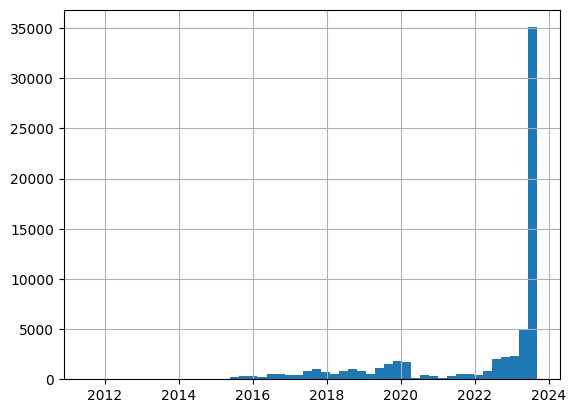

In [4]:
# Converting the 'last_review' column to datetime format for easier handling and analysis
df_listings['last_review'] = pd.to_datetime(df_listings['last_review'])
# Plotting a histogram of the 'last_review' dates to visualize the distribution of the last review dates across the dataset
df_listings['last_review'].hist(bins=50)

In [5]:
print("Number of listings with the last review made within the past 12 months", df_listings[df_listings['last_review'] > '2022-10-19'].shape)
print("Number of listings with the last review made more than 12 months ago", df_listings[df_listings['last_review'] <= '2022-10-19'].shape)

Number of listings with the last review made within the past 12 months (43600, 75)
Number of listings with the last review made more than 12 months ago (22188, 75)


In [6]:
# Calculating the proportion of missing values in the 'last_review' column by dividing the number of NaN values by the total number of rows in the dataframe
df_listings['last_review'].isna().sum() / df_listings.shape[0]

0.25195006026425304

We can observe that about 50% of the last reviews were made in the past 12 months, 25% were made more than a year ago, and 25% did not receive a last review.

This can indicate that a significant portion of the listings remains active and relevant, with half of them receiving feedback within the last year. However, there is a considerable number of listings that either have become less popular or inactive, as indicated by the 25% that have not received recent reviews. The remaining 25% without a last review could be newer listings that have not yet received feedback or listings that are not attracting guests for various reasons.

This data can be instrumental for Airbnb to identify patterns and trends in guest preferences and the performance of listings. It can help in developing strategies to enhance the visibility and attractiveness of listings that are not receiving reviews and understand the factors contributing to the popularity of those that are actively reviewed.

<Axes: >

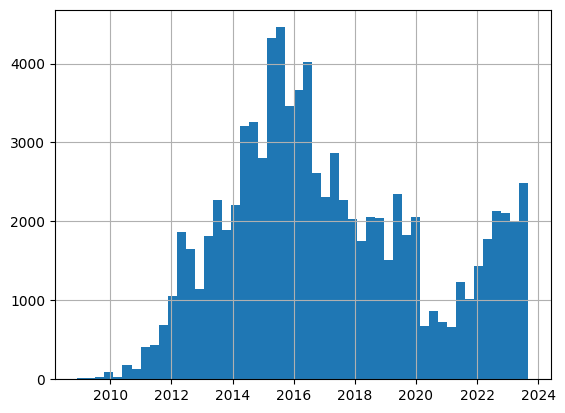

In [7]:
# Converting the 'host_since' column to datetime format to facilitate further analysis
df_listings['host_since'] = pd.to_datetime(df_listings['host_since'])
# Plotting a histogram of the 'host_since' column with 50 bins to visualize the distribution of the dates when the hosts joined
df_listings['host_since'].hist(bins=50)

<Axes: >

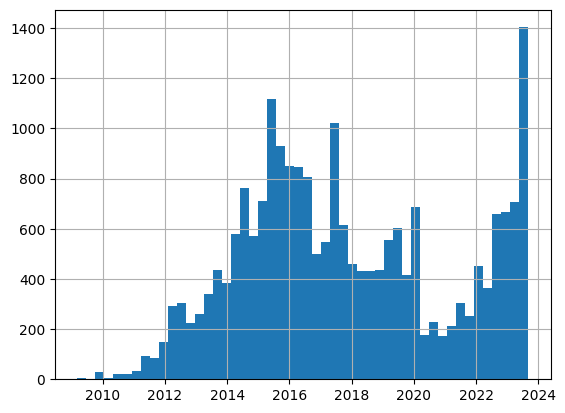

In [8]:
# Filtering the DataFrame to include only the listings with NaN values in the 'last_review' column
listings_without_last_review = df_listings[df_listings['last_review'].isna()]
# Plotting a histogram of the 'host_since' column with 50 bins to visualize the distribution of the dates when the hosts joined
listings_without_last_review['host_since'].hist(bins=50)

In [9]:
print('Number of new hosts without reviews before October 2022:', listings_without_last_review[listings_without_last_review['host_since'] <= '2022-10-19'].shape[0])
print('Number of new hosts without reviews after October 2022:', listings_without_last_review[listings_without_last_review['host_since'] > '2022-10-19'].shape[0])

Number of new hosts without reviews before October 2022: 19367
Number of new hosts without reviews after October 2022: 2786


Based on the numbers above, we can observe that a large portion of hosts without reviews have been on the platform for more than a year, and only 12% would be considered new entrants to the Airbnb platform.

<Axes: xlabel='host_since'>

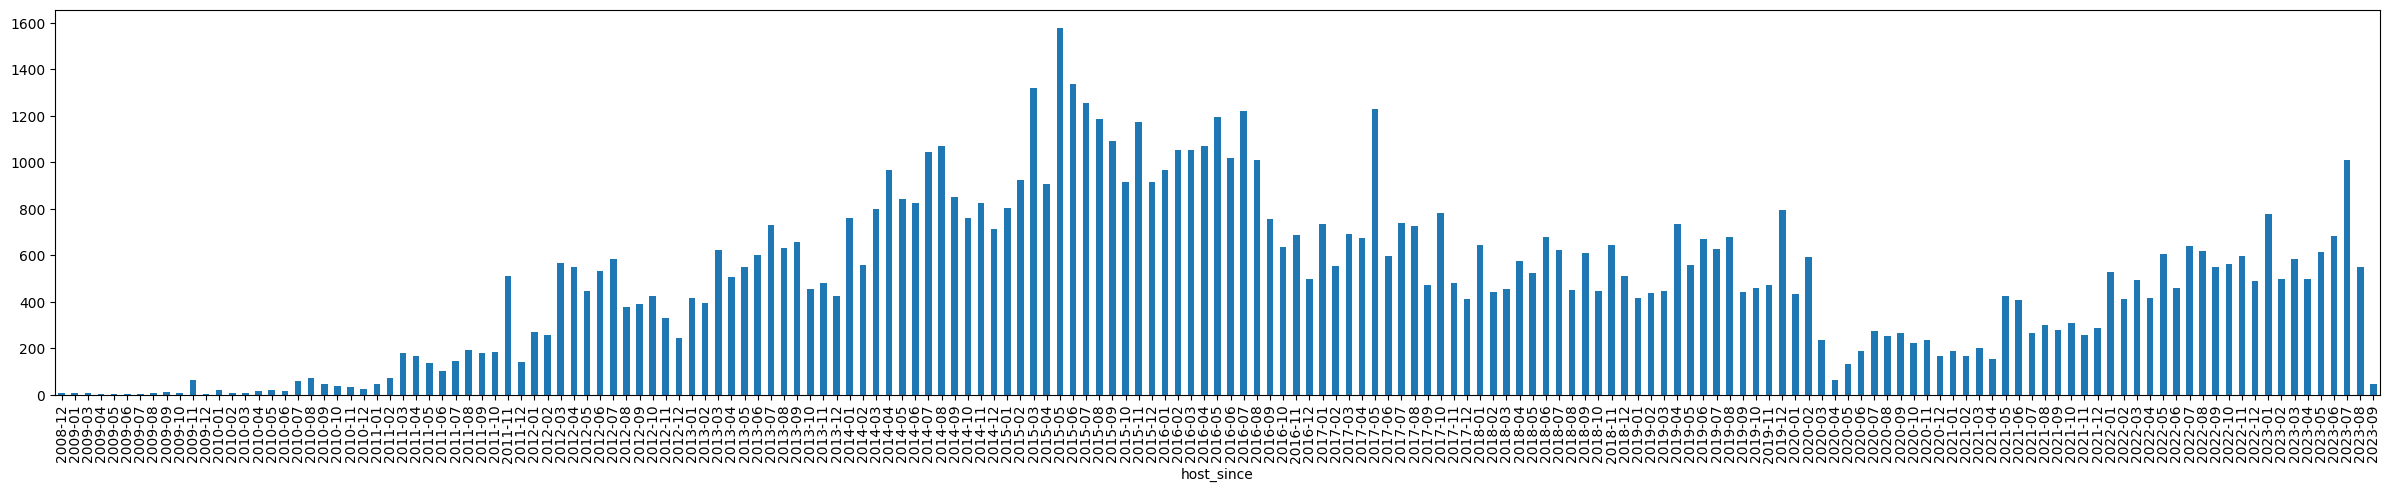

In [10]:
# Grouping the listings by the month and year when the host joined (host_since), and counting the number of listings for each period
# Plotting a bar chart of the counts, with a specified figure size to ensure readability
df_listings.groupby(df_listings['host_since'].dt.to_period('M')).size().plot(kind='bar', figsize=(30, 5))

Looking at the graph above, we can answer our first question:

#### 1. How is the entry of new hosts into the market?

We can see that the entry of new hosts into the market has grown significantly since the beginning in 2008 until about 2015, when it peaked in May 2015. From then on, the entry of new hosts into the market began to decrease significantly until April 2020, and since then it has been rising again.

This trend could be attributed to various factors The initial surge until 2015 can likely be linked to the escalating popularity of the Airbnb platform, leading to more individuals becoming hosts. The decline post-2015 could potentially be a result of market saturation, regulatory challenges, or other external factors impacting the sharing economy - a hypothesis that might be explored further in the article [here](https://www.sciencedirect.com/science/article/pii/S0160738323000786). The resurgence post-2020 suggests a revival and renewed interest in hosting, possibly driven by the evolving travel and accommodation preferences in the post-pandemic era.

Understanding these dynamics is pivotal for Airbnb to strategize its market expansion, host engagement, and support initiatives effectively.

foi desconsiderada a ideia que 1 host pode ter mais de 1 listing nessa análise, porém como podemos observar abaixo, diversos hosts possuem mais de 1 listing.

The next line of code groups the listings by host ID, counts the number of listings each host has, sorts them in descending order, and displays the top 10 hosts with the most listings.

In [11]:
df_listings.groupby('host_id').id.count().sort_values(ascending=False).head(10)

host_id
129230780    595
33889201     312
314162972    301
28820321     288
1432477      259
258154594    233
269308503    202
48165024     200
156158778    195
439074505    170
Name: id, dtype: int64

The next line of code groups the listings by host ID and counts the number of listings each host has. It then counts the frequency of each quantity of listings (i.e., how many hosts have 1 listing, 2 listings, etc.), sorts these frequencies in descending order, and displays the top 10 most common quantities of listings that hosts have.

In [12]:
df_listings.groupby('host_id').id.count().sort_values(ascending=False).value_counts().head(10)

id
1     43381
2      5636
3      1743
4       808
5       437
6       289
7       202
8       125
9       103
10       86
Name: count, dtype: int64

In [13]:
# Converting the 'first_review' column to datetime format to facilitate time series analysis and other operations that require datetime format.
df_listings['first_review'] = pd.to_datetime(df_listings['first_review'])

In [14]:
# Loading the GeoJSON file containing the geographical data of London's neighbourhoods into a GeoDataFrame.
geo_london = gpd.read_file('data/neighbourhoods.geojson')

There are no listings available for the year 2008.


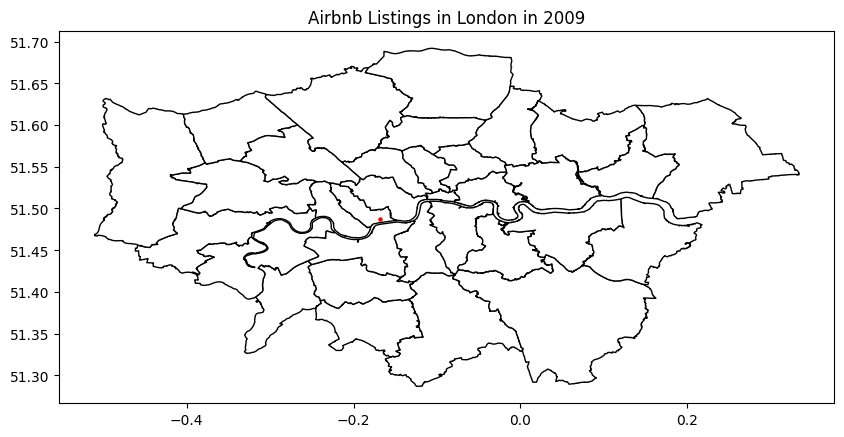

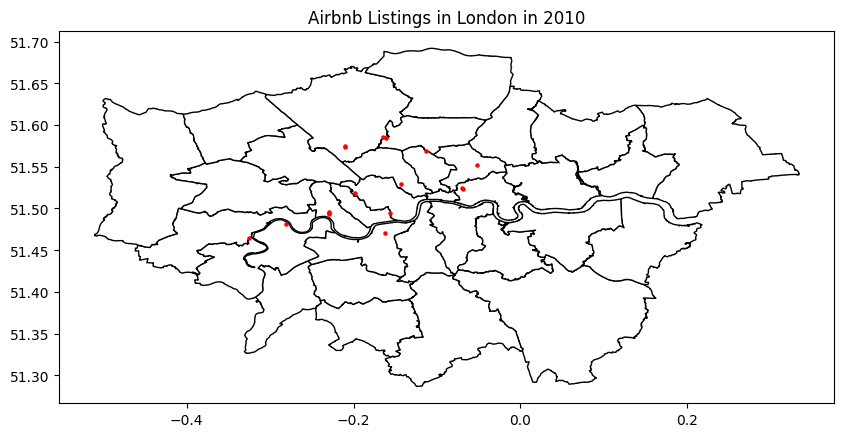

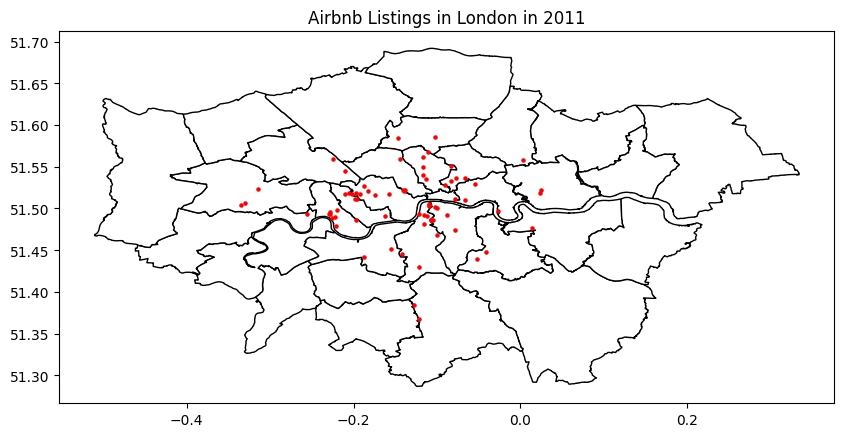

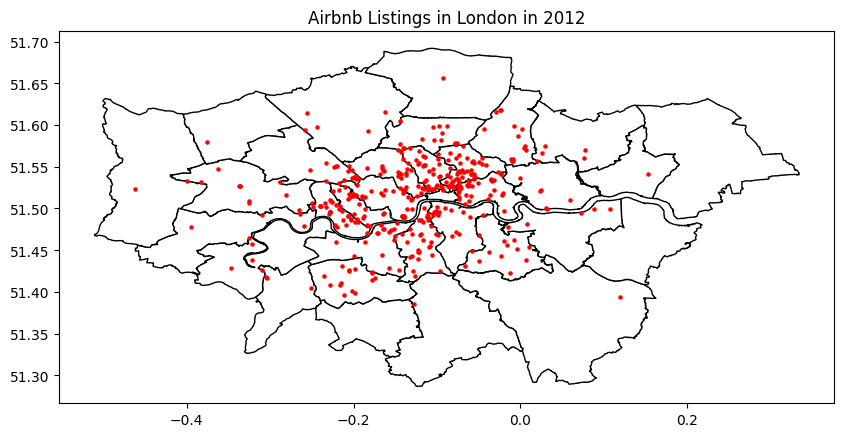

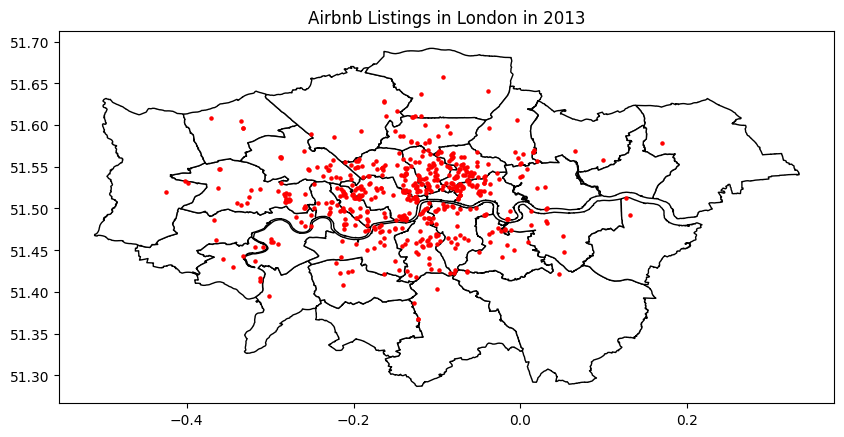

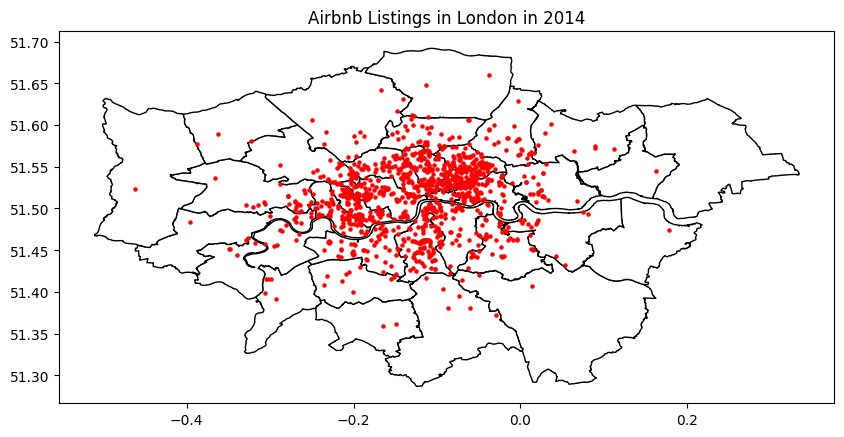

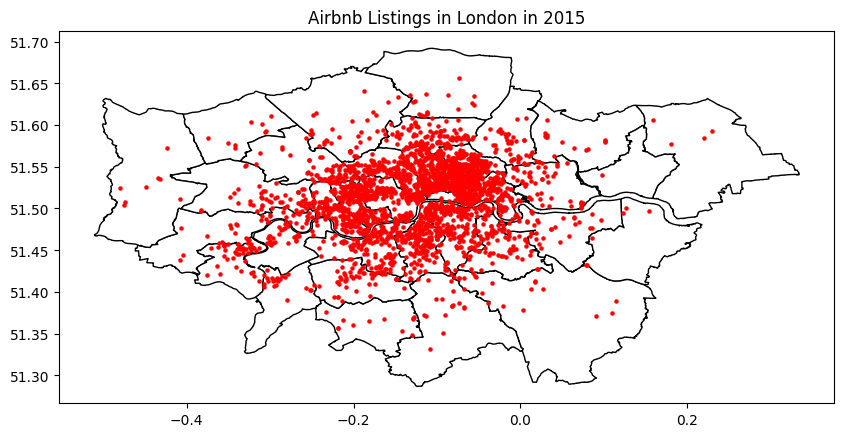

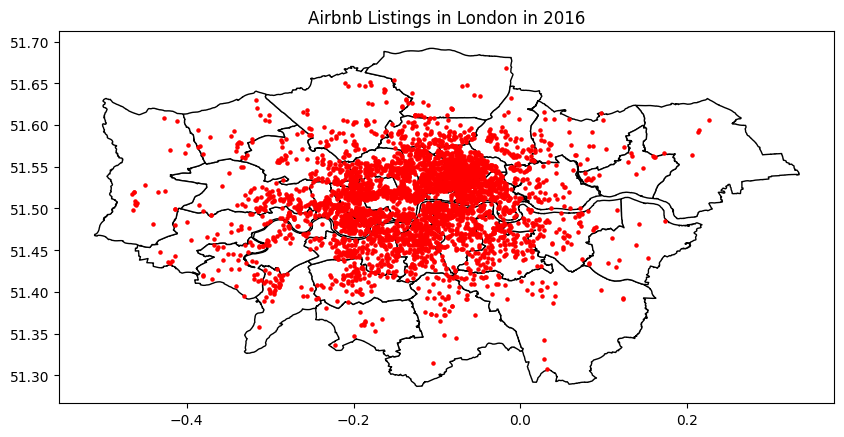

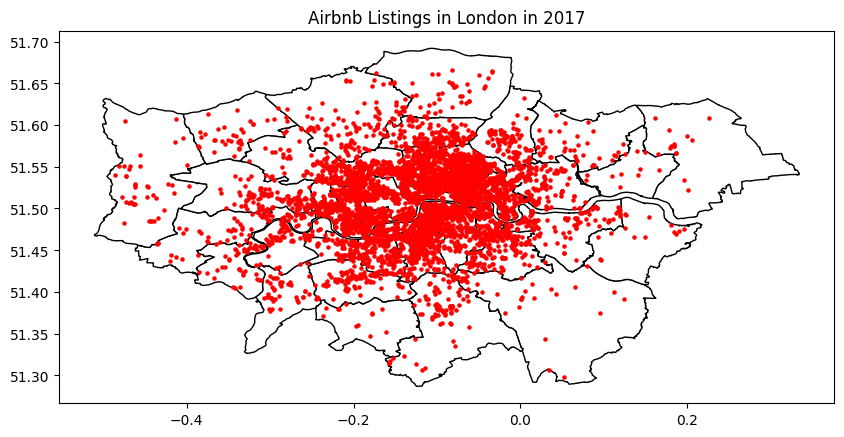

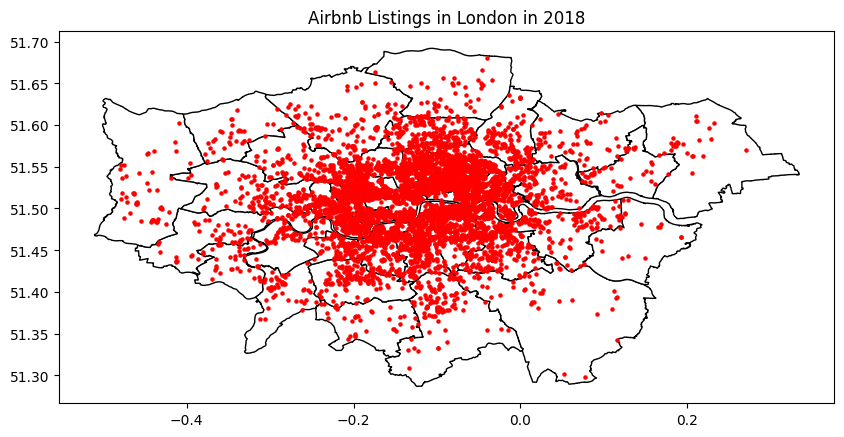

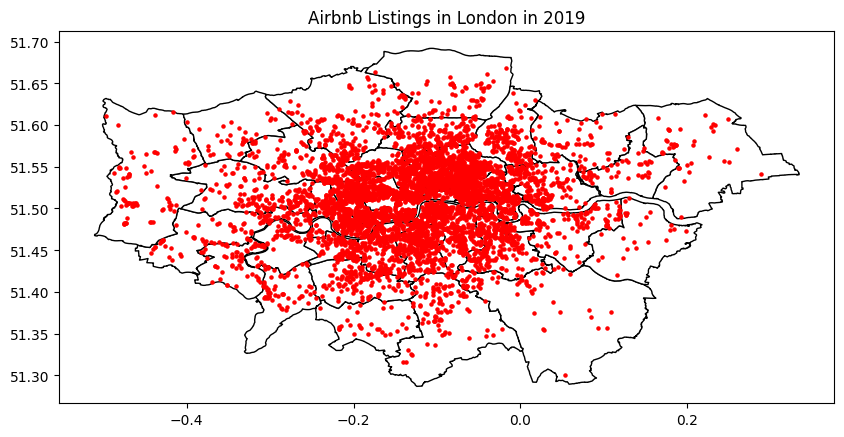

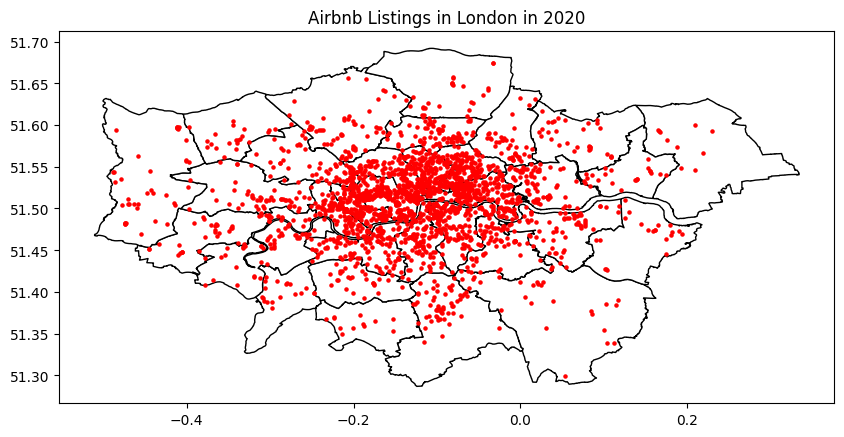

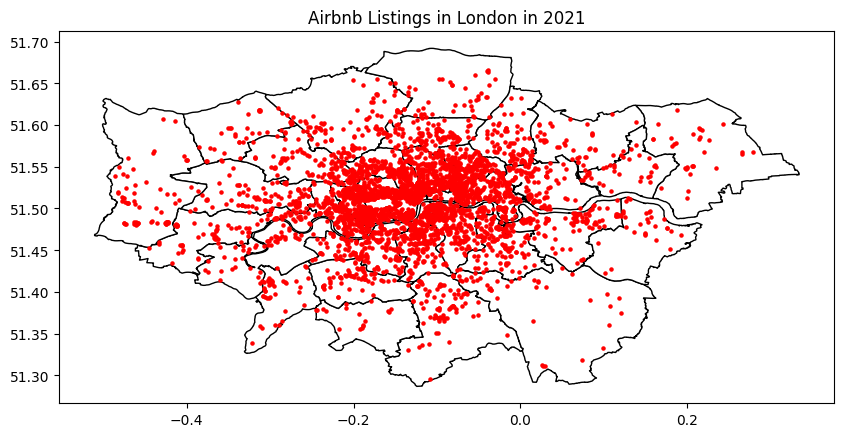

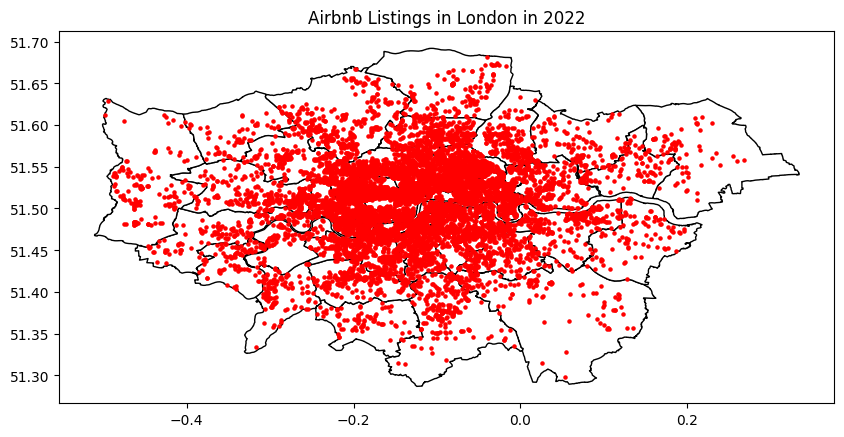

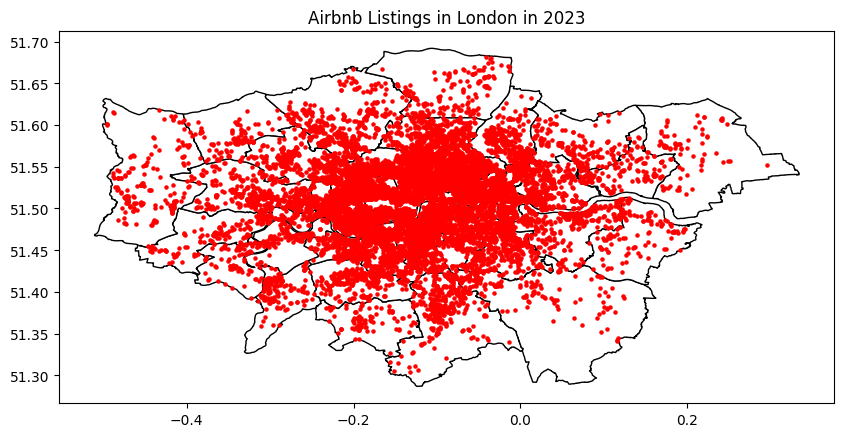

In [15]:
for year in range(2008, 2024):
    # Filtering the listings by year
    df_year = df_listings[df_listings['first_review'].dt.year == year]
    
    # Checking if there are listings for the year
    if not df_year.empty:
        # Converting the coordinates into a Point object
        geometry = [Point(xy) for xy in zip(df_year['longitude'], df_year['latitude'])]

        # Converting the DataFrame into a GeoDataFrame
        gdf_year = gpd.GeoDataFrame(df_year, geometry=geometry)

        # Plotting the map of London
        ax = geo_london.plot(figsize=(10, 10), color='white', edgecolor='black')

        # Plotting the Airbnb listings
        gdf_year.plot(ax=ax, color='red', markersize=5)

        # Adding a title with the year
        plt.title(f'Airbnb Listings in London in {year}')

        # Showing the plot
        plt.show()
    else:
        print(f"There are no listings available for the year {year}.")


<Axes: title={'center': 'Number of Listings by Year of First Review'}, xlabel='first_review'>

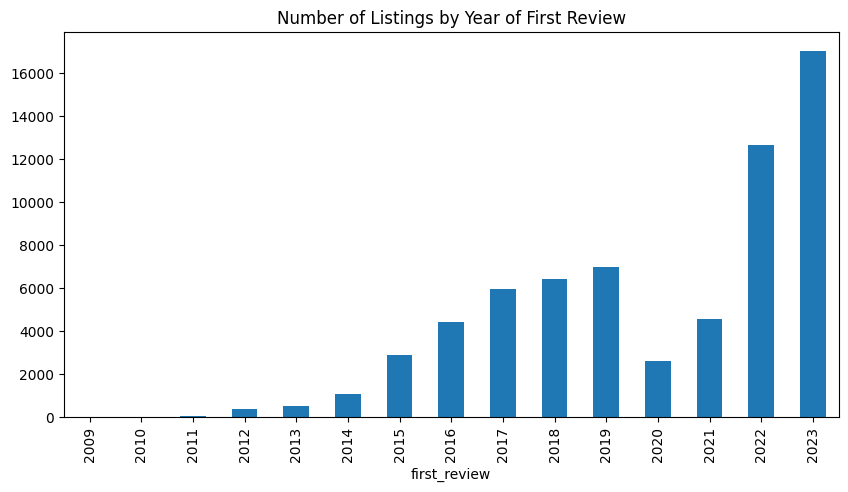

In [16]:
# Grouping the listings by the year of their first review and plotting the count of listings per year as a bar chart.
df_listings.groupby(df_listings['first_review'].dt.to_period('Y')).size().plot.bar(
    title='Number of Listings by Year of First Review',  # Adding a title to the bar chart for clarity.
    figsize=(10, 5)  # Specifying the figure size to ensure readability.
)

<Axes: title={'center': 'Number of Listings by Year Host Joined'}, xlabel='host_since'>

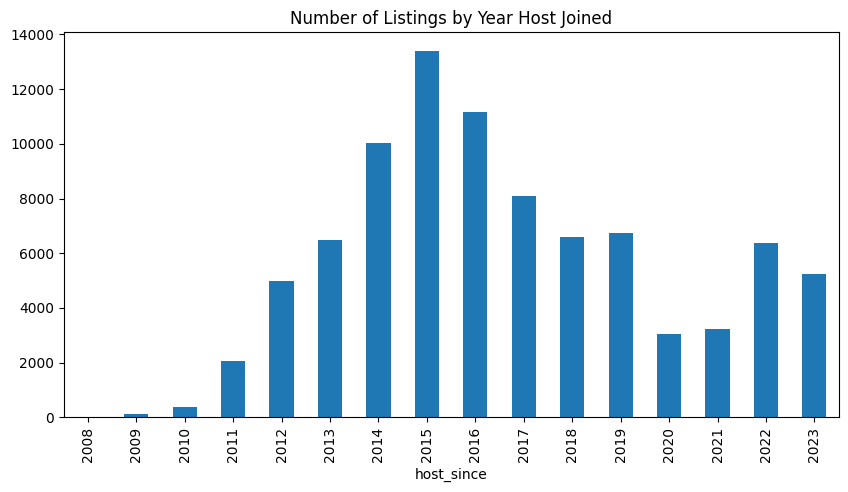

In [17]:
# Grouping the listings by the year the host joined and plotting the count of listings per year as a bar chart.
df_listings.groupby(df_listings['host_since'].dt.to_period('Y')).size().plot.bar(
    title='Number of Listings by Year Host Joined',  # Adding a title to the bar chart for clarity.
    figsize=(10, 5)  # Specifying the figure size to ensure readability.
)


Looking at the graphs above, we can answer the second question:

#### 2. Based on the first review, how has the market grown geographically?

We can clearly see that there was a decline in 2020, but since then, the market has been recovering.

The geographical spread of Airbnb listings over the years illustrates the platform's growing popularity and reach. In the initial years, the listings were predominantly located in central London, catering primarily to tourists and business travelers seeking proximity to major attractions and business districts.

However, as the platform gained traction, more homeowners and renters across various neighborhoods started listing their properties, leading to a more diverse and widespread geographical distribution. This expansion can be attributed to several factors, including increased awareness of Airbnb, the platform's ease of use, and the potential for additional income.

The decline in 2020 is likely due to the impact of the COVID-19 pandemic, which brought about travel restrictions and a significant reduction in tourism. This period saw a decrease in new reviews as potential travelers postponed or canceled their plans.

The subsequent recovery indicates the resilience of the sharing economy and people’s adaptability. Property owners and hosts have started to adapt to the new normal, implementing enhanced cleaning protocols and flexible booking options to attract guests. The spread of listings throughout the city also underscores the increased preference for localized experiences, with travelers seeking accommodations in residential neighborhoods to immerse themselves in the local culture.

In conclusion, the geographical growth of Airbnb listings in London underscores the dynamic nature of the sharing economy and its ability to adapt and thrive amidst challenges. The widespread distribution of listings across the city indicates a mature and diverse market, offering a plethora of options for travelers and opportunities for hosts.

#### Comments

Comparing the growth based on the year the host entered the market with the first review made by a user, we can observe different growth trajectories. The growth based on the year the host joined indicates a rapid initial increase, followed by a decline, and then a resurgence post-2022. This could be attributed to the initial novelty and excitement surrounding the Airbnb platform, followed by a period of stabilization as the market matured, and then a renewed interest possibly spurred by changes in travel trends or improvements in the platform.

On the other hand, the growth informed by the first review reveals a slower initial pace, an acceleration over time, a dip in 2020 - likely due to the pandemic - and a subsequent rebound post-2020. This pattern suggests that while the number of hosts joining the platform was initially high, the rate at which they received their first reviews was slower. The acceleration in reviews over time could indicate an increase in platform usage and trust among users. The dip in 2020 is understandably linked to the global travel restrictions and health concerns due to COVID-19.

These insights are crucial as they not only reflect the hosts' and guests' behavior over the years but also are indicative of the external factors influencing these patterns. For Airbnb, understanding these nuanced dynamics is essential to tailor their strategies for host acquisition, guest engagement, and overall platform enhancement to align with the evolving trends and challenges. 

Additionally, it underscores the importance of considering both the hosts' entry into the market and the guests' engagement (as indicated by the first reviews) to gain a comprehensive insight into the platform’s growth and challenges. Each provides a unique perspective, and together they offer a holistic view of the ecosystem's evolution.

In [18]:
# Replacing any occurrence of '$' or ',' in the 'price' column with an empty string and converting the column to float type for numerical operations
df_listings['price'] = df_listings['price'].replace('[\$,]', '', regex=True).astype(float)
# Displaying the statistical summary (count, mean, std deviation, min, 25th percentile, median, 75th percentile, max) of the 'price' column
df_listings['price'].describe()

count    87946.000000
mean       181.349817
std        486.174310
min          0.000000
25%         63.000000
50%        110.000000
75%        193.000000
max      80100.000000
Name: price, dtype: float64

<Axes: >

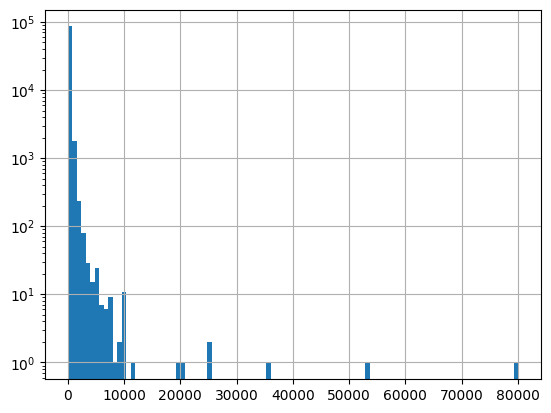

In [19]:
# Plotting a histogram of the 'price' column with a logarithmic scale for the y-axis and 100 bins to better visualize the distribution of prices
df_listings['price'].hist(log=True, bins=100)

<Axes: >

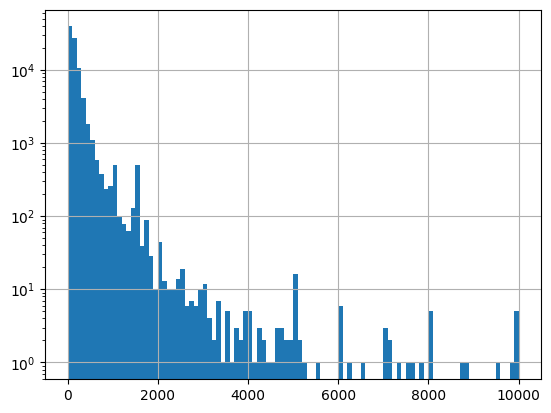

In [20]:
# Filtering the dataset to include only listings with a price less than 10,000 to eliminate extreme outliers
df_listings_price_less_10_000 = df_listings[df_listings['price'] < 10_000]
# Plotting a histogram of the filtered 'price' data with a logarithmic scale for the y-axis and 100 bins for a more detailed view of the distribution
df_listings_price_less_10_000['price'].hist(log=True, bins=100)

In [21]:
# Displaying the statistical summary 
df_listings_price_less_10_000['price'].describe()

count    87933.000000
mean       177.713862
std        294.174828
min          0.000000
25%         63.000000
50%        110.000000
75%        193.000000
max       9999.000000
Name: price, dtype: float64

<Axes: >

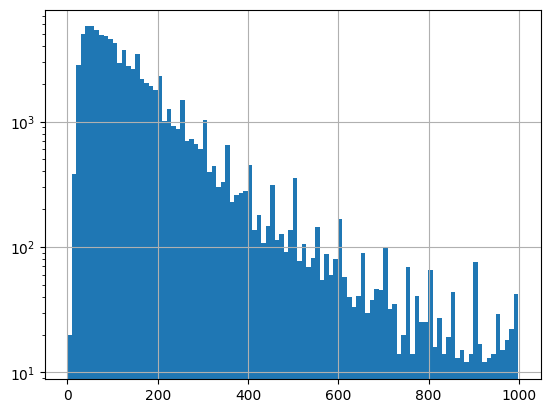

In [22]:
# Filtering the dataset to include only listings with a price less than 1,000 to eliminate extreme outliers
df_listings_price_less_1_000 = df_listings[df_listings['price'] < 1_000]
# Plotting a histogram of the filtered 'price' data with a logarithmic scale for the y-axis and 100 bins for a more detailed view of the distribution
df_listings_price_less_1_000['price'].hist(log=True, bins=100)

In [23]:
# Displaying the statistical summary
df_listings_price_less_1_000['price'].describe()

count    86152.000000
mean       146.988091
std        130.865827
min          0.000000
25%         61.000000
50%        107.000000
75%        185.000000
max        999.000000
Name: price, dtype: float64

In [24]:
# Filtering the dataset to include only listings with a price less than 10 to eliminate extreme outliers
df_listings_price_less_10 = df_listings[df_listings['price'] < 10]
# Displaying the total number of listings with a price less than 10 to understand the size of this subset
df_listings_price_less_10['price'].shape

(20,)

In [25]:
# Providing descriptive statistics for listings priced less than 10 to gain insights into the central tendency and spread of this subset of data
df_listings_price_less_10['price'].describe()

count    20.000000
mean      5.400000
std       3.676383
min       0.000000
25%       1.000000
50%       8.000000
75%       8.000000
max       9.000000
Name: price, dtype: float64

In [26]:
def remove_outliers_from_list(data):
    """
    Remove outliers from a list of numbers using the IQR method.

    Parameters:
    - data: list of numbers

    Returns:
    - A new list with outliers removed
    """
    # Converting the list into a DataFrame
    df = pd.DataFrame(data, columns=['value'])

    # Calculating the first and third quartiles
    Q1 = df['value'].quantile(0.25)
    Q3 = df['value'].quantile(0.75)
    
    # Calculating the Interquartile Range (IQR)
    IQR = Q3 - Q1

    # Defining bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Removing outliers
    df_no_outliers = df[(df['value'] >= lower_bound) & (df['value'] <= upper_bound)]

    # Converting the DataFrame back into a list
    no_outliers_list = df_no_outliers['value'].tolist()

    return no_outliers_list


In [27]:
# Apply the remove_outliers_from_list function to the 'price' column of the DataFrame and convert the result into a pandas Series
listings_price_without_outliers = pd.Series(remove_outliers_from_list(df_listings['price'].tolist()))
# Display descriptive statistics for the prices after outlier removal to understand the distribution characteristics
listings_price_without_outliers.describe()

count    81465.000000
mean       123.442656
std         80.928385
min          0.000000
25%         60.000000
50%        100.000000
75%        169.000000
max        388.000000
dtype: float64

#### 3. Given these insights, how can businesses and investors leverage this refined data to identify untapped opportunities and optimize their pricing strategies to maximize profitability and competitiveness in the London Airbnb market?

In examining the Airbnb price listing data, we uncover valuable insights that hold substantial business implications. Initially, the average price across all listings stands at approximately $181.35. However, a significant standard deviation of $486.17 underscores a broad price variation, accentuated by an extreme maximum price of $80,100, pointing towards the presence of outliers.

Refining the dataset to exclude listings priced above $10,000 brings the average down to $177.71 and the standard deviation to $294.17. This adjustment underscores the inflationary impact of high-priced outliers on the overall data. With 87,933 listings priced below $10,000, it’s evident that the bulk of the market operates within this range, offering a more realistic snapshot of the prevailing pricing trends.

The business value here lies in understanding the actual market dynamics, free from the distortion caused by extreme values. Companies can align their pricing strategies, competitive analyses, and market positioning efforts based on a more accurate representation of the market landscape.

Diving deeper, filtering listings to those priced under $1,000 reveals an average price of $146.99 and a standard deviation of $130.87. With 86,152 listings in this category, it’s clear that affordability is a dominant theme in the London Airbnb market. This insight is crucial for stakeholders aiming to tailor their offerings to meet the prevailing market demand, optimize pricing to enhance competitiveness, and identify gaps and opportunities in the market.

Interestingly, there are 20 listings priced below $10, with an average price of $5.40. While numerically insignificant, these listings could represent unique, niche offerings or data inaccuracies that warrant further investigation.

Implementing the IQR method to eliminate outliers presents us with 81,465 listings (92% of the total), an average price of $123.44, and a standard deviation of $80.93. The business implication is profound; with outliers removed, businesses and investors gain access to data that mirrors the true market conditions, enabling informed decision-making, strategic planning, and investment allocation.

In conclusion, these insights are instrumental for businesses, investors, and policymakers. They offer a granular view of the pricing landscape, enabling the development of strategies that are not only competitive but also aligned with the market’s pulse. The clarity and accuracy of this data empower stakeholders to make decisions that are both informed and strategic, driving profitability and market share growth.

In [28]:
# Retrieve the unique neighbourhoods from the 'neighbourhood_cleansed' column of the DataFrame
neighbourhoods = df_listings['neighbourhood_cleansed'].unique()
neighbourhoods

array(['Wandsworth', 'Hammersmith and Fulham', 'Islington',
       'Kensington and Chelsea', 'Greenwich', 'Westminster',
       'Tower Hamlets', 'Barnet', 'Lewisham', 'Brent', 'Lambeth',
       'Richmond upon Thames', 'Haringey', 'Southwark', 'Enfield',
       'Hounslow', 'Camden', 'Waltham Forest', 'City of London',
       'Hackney', 'Ealing', 'Croydon', 'Merton', 'Havering', 'Harrow',
       'Newham', 'Hillingdon', 'Barking and Dagenham', 'Bromley',
       'Kingston upon Thames', 'Redbridge', 'Bexley', 'Sutton'],
      dtype=object)

In [29]:
neighbourhoods_price_without_outliers = {}
neighbourhoods_review_scores_rating = {}

for neighbourhood in neighbourhoods:
    # Getting the prices for the specific neighbourhood
    prices = df_listings[df_listings['neighbourhood_cleansed'] == neighbourhood]['price'].tolist()
    
    # Removing outliers from the prices
    cleaned_prices = remove_outliers_from_list(prices)
    
    # Calculating the mean of the prices without outliers
    # Checking if cleaned_prices is not empty to avoid computing mean of an empty list
    mean_price = pd.Series(cleaned_prices).mean() if cleaned_prices else None
    
    # Storing the mean price in the dictionary
    neighbourhoods_price_without_outliers[neighbourhood] = mean_price
    
    # Calculating the mean of the review_scores_rating for listings without price outliers
    # Only proceed if cleaned_prices is not empty
    if cleaned_prices:
        min_price = min(cleaned_prices)
        max_price = max(cleaned_prices)
        cleaned_df = df_listings[(df_listings['neighbourhood_cleansed'] == neighbourhood) & 
                                 (df_listings['price'] >= min_price) & 
                                 (df_listings['price'] <= max_price)]
        mean_review_score = cleaned_df['review_scores_rating'].mean()
    else:
        mean_review_score = None
    
    # Storing the mean review_scores_rating in the dictionary
    neighbourhoods_review_scores_rating[neighbourhood] = mean_review_score


In [30]:
# Creating a new DataFrame from the dictionary of neighbourhoods' prices without outliers
# Also, adding the review scores rating for each neighbourhood to the DataFrame
df_price_rating = pd.DataFrame.from_dict(neighbourhoods_price_without_outliers, orient='index', columns=['price'])
df_price_rating['review_scores_rating'] = neighbourhoods_review_scores_rating.values()
df_price_rating.head()

,price,review_scores_rating
Wandsworth,125.575127,4.658565
Hammersmith and Fulham,135.295114,4.604016
Islington,117.694336,4.590339
Kensington and Chelsea,211.056523,4.563359
Greenwich,104.954350,4.594670


In [31]:
# Top 5 reviewed neighbourhoods
df_price_rating.sort_values(by='review_scores_rating', ascending=False).head()

,price,review_scores_rating
Kingston upon Thames,100.214502,4.731087
Richmond upon Thames,130.947368,4.703525
Bromley,85.712707,4.700945
Waltham Forest,89.877588,4.679711
Hackney,104.142415,4.673931


In [32]:
# Top 5 expensive neighbourhoods
df_price_rating.sort_values(by='price', ascending=False).head()

,price,review_scores_rating
Westminster,217.989719,4.535426
Kensington and Chelsea,211.056523,4.563359
City of London,179.649087,4.517020
Camden,150.068389,4.541262
Hammersmith and Fulham,135.295114,4.604016


In [33]:
# Top 5 cheapest neighbourhoods
df_price_rating.sort_values(by='price', ascending=True).head()

,price,review_scores_rating
Bexley,76.726115,4.606863
Croydon,77.122020,4.573645
Sutton,78.498630,4.661357
Redbridge,83.121739,4.574056
Hillingdon,84.170316,4.507129


In [34]:
# Mean review score rating for the Top 5 expensive neighbourhoods
df_price_rating.sort_values(by='price', ascending=False).head()['review_scores_rating'].mean()

4.55221630533746

In [35]:
# Mean review score rating for the Top 5 cheapest neighbourhoods
df_price_rating.sort_values(by='price', ascending=True).head()['review_scores_rating'].mean()

4.584610238142757

In [36]:
top_cheapest_neighbourhoods = df_price_rating.sort_values(by='price', ascending=True).head().index.tolist()
top_cheapest_neighbourhoods

['Bexley', 'Croydon', 'Sutton', 'Redbridge', 'Hillingdon']

In [37]:
top_expensive_neighbourhoods = df_price_rating.sort_values(by='price', ascending=False).head().index.tolist()
top_expensive_neighbourhoods

['Westminster',
 'Kensington and Chelsea',
 'City of London',
 'Camden',
 'Hammersmith and Fulham']

In [38]:
def get_reviews_of_neighbourhoods(neighbourhoods, df):
    """Function to get all reviews from neighbourhoods, removing price outliers

    Args:
        neighbourhoods (list): List of neighbourhoods
        df (DataFrame): DataFrame with the listings

    Returns:
        list: List of reviews
    """
    reviews = []
    for neighbourhood in neighbourhoods:
        # Getting the prices for the specific neighbourhood
        prices = df[df['neighbourhood_cleansed'] == neighbourhood]['price'].tolist()
        
        # Removing outliers from the prices
        cleaned_prices = remove_outliers_from_list(prices)
        
        # Checking if cleaned_prices is not empty to avoid errors
        if cleaned_prices:
            min_price = min(cleaned_prices)
            max_price = max(cleaned_prices)
            
            # Filtering the DataFrame based on the neighbourhood and cleaned prices
            cleaned_df = df[(df['neighbourhood_cleansed'] == neighbourhood) & 
                            (df['price'] >= min_price) & 
                            (df['price'] <= max_price)]
            
            # Adding the reviews to the list
            reviews.extend(cleaned_df['review_scores_rating'].dropna().tolist())  
    return reviews

In [39]:
cheapest_neighbourhoods_reviews = get_reviews_of_neighbourhoods(top_cheapest_neighbourhoods, df_listings)
expensive_neighbourhoods_reviews = get_reviews_of_neighbourhoods(top_expensive_neighbourhoods, df_listings)

print("Reviews from the Cheapest Neighbourhoods:")
print(cheapest_neighbourhoods_reviews[:5])

print("\nReviews from the Most Expensive Neighbourhoods:")
print(expensive_neighbourhoods_reviews[:5])

Reviews from the Cheapest Neighbourhoods:
[4.88, 4.24, 4.44, 5.0, 5.0]

Reviews from the Most Expensive Neighbourhoods:
[4.76, 4.73, 4.91, 4.5, 4.82]


<Axes: >

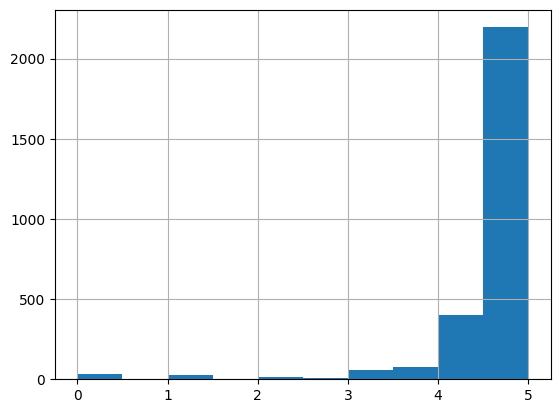

In [40]:
# Plotting a histogram of the review scores of the cheapest neighbourhoods
# This visualization helps in understanding the distribution of review scores in the most affordable areas
pd.Series(cheapest_neighbourhoods_reviews).hist()

<Axes: >

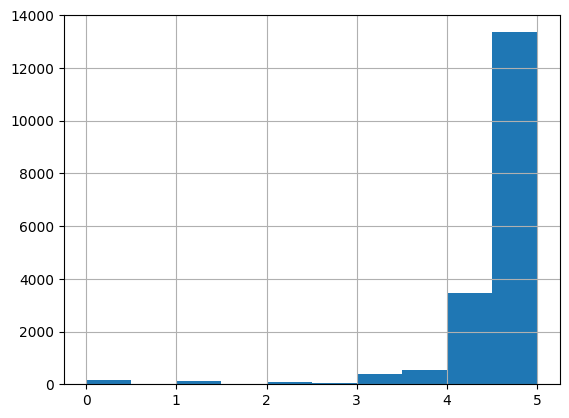

In [41]:
# Plotting a histogram of the review scores of the most expensive neighbourhoods
# This visualization aids in analyzing the distribution of review scores in the pricier areas
pd.Series(expensive_neighbourhoods_reviews).hist()

In [42]:
# Printing the number of reviews in the most expensive and cheapest neighbourhoods
# This helps in understanding the volume of feedback received in both categories of neighbourhoods
len(expensive_neighbourhoods_reviews), len(cheapest_neighbourhoods_reviews)

(18189, 2815)

In [43]:
# Calculating and printing the average review score for the most expensive neighbourhoods
# This provides an insight into the general satisfaction level of guests staying in these areas
sum(expensive_neighbourhoods_reviews) / len(expensive_neighbourhoods_reviews)

4.552690087415461

In [44]:
# This code snippet calculates the average review score for the cheapest neighbourhoods.
# It sums up all the review scores of the cheapest neighbourhoods and divides it by the total number of reviews.
# This average score can give an insight into the quality or satisfaction level associated with accommodation in these budget-friendly areas.
sum(cheapest_neighbourhoods_reviews) / len(cheapest_neighbourhoods_reviews)

4.571602131438711

In [45]:
# Calculating the Mann-Whitney U test
stat, p_value = mannwhitneyu(cheapest_neighbourhoods_reviews, expensive_neighbourhoods_reviews, alternative='greater')

# Printing the results
print(f"Test statistic: {stat}")
print(f"P-value: {p_value}")

# Setting the significance level
alpha = 0.05

# Checking whether to reject or fail to reject the null hypothesis
if p_value < alpha:
    print("We reject the null hypothesis. There is sufficient evidence to conclude that cheaper neighbourhoods have significantly higher review ratings.")
else:
    print("We fail to reject the null hypothesis. There is not sufficient evidence to conclude that cheaper neighbourhoods have significantly higher review ratings.")


Test statistic: 28041185.5
P-value: 9.92739511163037e-17
We reject the null hypothesis. There is sufficient evidence to conclude that cheaper neighbourhoods have significantly higher review ratings.


#### 4. Is there a statistically significant difference in the review ratings between the cheaper and more expensive neighborhoods in London, and if so, what might be the underlying factors influencing this trend?

After analyzing the distribution of listing prices in the city of London, I decided to observe how this price varies from neighborhood to neighborhood. I encountered a counterintuitive data point: it appears that the top 5 neighborhoods with lower prices have higher review ratings than the top 5 neighborhoods with higher prices.

To delve deeper into this analysis, I removed the outlier values and conducted a comparison using the Mann-Whitney U test, as the review ratings apparently do not follow a normal distribution.

The results of the Mann-Whitney U test show a very small p-value (9.93e-17), which is much lower than the common significance level of 0.05. This means we reject the null hypothesis.

Rejecting the null hypothesis indicates that there is a statistically significant difference in review ratings between the cheaper and more expensive neighborhoods. Since the test was conducted with the alternative that the ratings of the cheaper neighborhoods are higher, the results suggest that the cheaper neighborhoods have significantly higher review ratings than the more expensive ones.

This can be counterintuitive, as it is often assumed that more expensive areas offer superior stay quality, reflected in higher review ratings. However, the results suggest the opposite. There could be several factors contributing to this, including guests expectations, perceived value, and other qualitative factors that are not captured by price alone.

In [46]:
# Displaying the count of each unique property type in the dataset again.
# This helps in understanding the distribution and popularity of different types of properties listed on Airbnb.
df_listings['property_type'].value_counts()

property_type
Entire rental unit                   33700
Private room in rental unit          14455
Private room in home                 10679
Entire condo                          8696
Entire home                           7557
                                     ...  
Shared room in serviced apartment        1
Yurt                                     1
Earthen home                             1
Private room in camper/rv                1
Private room in cave                     1
Name: count, Length: 102, dtype: int64

In [47]:
# Calculating the cumulative sum of the relative frequencies of the top 20 property types.
# This provides insights into the proportion of listings represented by the most common property types.
df_listings['property_type'].value_counts(True).head(20).cumsum()

property_type
Entire rental unit                    0.383190
Private room in rental unit           0.547552
Private room in home                  0.668979
Entire condo                          0.767858
Entire home                           0.853785
Private room in condo                 0.891763
Entire serviced apartment             0.914845
Private room in townhouse             0.930241
Entire townhouse                      0.943363
Room in hotel                         0.950288
Private room in bed and breakfast     0.956678
Entire loft                           0.961215
Private room in guesthouse            0.965104
Room in boutique hotel                0.968344
Entire guesthouse                     0.970675
Private room in loft                  0.972790
Entire guest suite                    0.974848
Shared room in rental unit            0.976872
Private room in serviced apartment    0.978873
Private room in guest suite           0.980772
Name: proportion, dtype: float64

In [48]:
# Calculating the cumulative sum of the relative frequencies of the top 7 property types.
# This helps to quickly visualize the proportion of listings that are covered by these common types.
df_listings['property_type'].value_counts(True).head(7).cumsum()

property_type
Entire rental unit             0.383190
Private room in rental unit    0.547552
Private room in home           0.668979
Entire condo                   0.767858
Entire home                    0.853785
Private room in condo          0.891763
Entire serviced apartment      0.914845
Name: proportion, dtype: float64

We observe that there are over 100 distinct types of properties listed on Airbnb. However, a closer examination reveals that the top seven categories account for more than 90% of the total listings. This concentration suggests a predominant preference or availability of certain types of accommodations. Given this insight, it would be prudent to focus our subsequent analysis on these seven primary property types. This targeted approach will enable a more concise and relevant exploration, ensuring that our findings are both meaningful and actionable in the context of the prevailing market dynamics.

In [49]:
# Extracting the 7 most common property types in the dataset.
# These types are predominant and represent a significant portion of the listings.
predominant_property_types = df_listings['property_type'].value_counts(True).head(7).index.tolist()
predominant_property_types

['Entire rental unit',
 'Private room in rental unit',
 'Private room in home',
 'Entire condo',
 'Entire home',
 'Private room in condo',
 'Entire serviced apartment']

In [50]:
# Calculating the average price for each of the 7 most common property types.
# This will help in understanding the price distribution across different types of properties.
mean_price_property = df_listings[df_listings['property_type'].isin(predominant_property_types)].groupby('property_type')['price'].mean().sort_values()
mean_price_property

property_type
Private room in home            64.821144
Private room in condo           83.326347
Private room in rental unit    111.222414
Entire condo                   203.940087
Entire rental unit             207.818724
Entire home                    308.017864
Entire serviced apartment      316.144335
Name: price, dtype: float64

In [51]:
# Calculating the average review score for each of the 7 most common property types.
# This will help in understanding the guest satisfaction level across different types of properties.
mean_review_score_property = df_listings[df_listings['property_type'].isin(predominant_property_types)].groupby('property_type')['review_scores_rating'].mean().sort_values()
mean_review_score_property

property_type
Entire serviced apartment      4.457985
Private room in rental unit    4.522198
Entire rental unit             4.575746
Private room in home           4.600950
Entire home                    4.652255
Entire condo                   4.694043
Private room in condo          4.733672
Name: review_scores_rating, dtype: float64

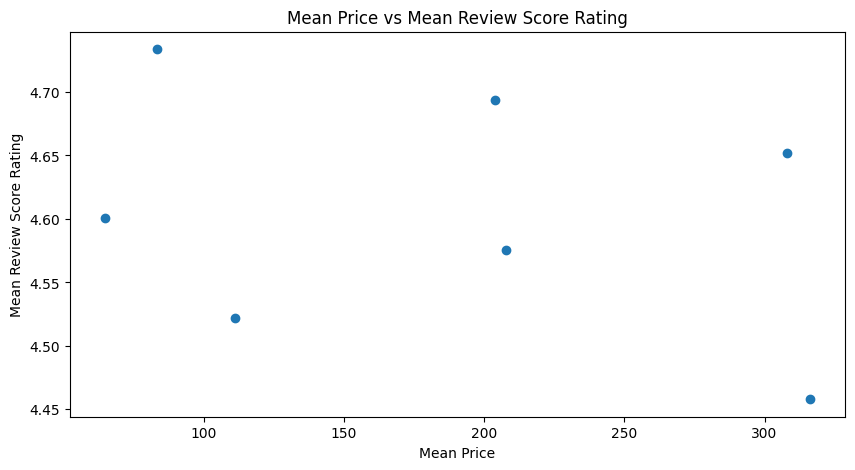

In [52]:
# Creating a scatter plot to visualize the relationship between the mean price and mean review score rating of the 7 most common property types.
# This will help to analyze if there is a correlation between the price and the satisfaction of the guests.
plt.figure(figsize=(10, 5))
plt.scatter(mean_price_property.sort_index(), mean_review_score_property.sort_index())
plt.xlabel('Mean Price')
plt.ylabel('Mean Review Score Rating')
plt.title('Mean Price vs Mean Review Score Rating')
plt.show()

In [53]:
# Calculating the correlation coefficient between the mean price and mean review score rating for the predominant property types.
# This will give a numerical measure of the strength and direction of the relationship between the two variables.
mean_price_property.corr(mean_review_score_property)

-0.31752354731250015

In [54]:
# Fitting a linear model to the data to understand the relationship between mean price and mean review score rating.
# This will provide the coefficients that minimize the error in the linear equation y = mx + b.
model = np.polyfit(mean_price_property.sort_index(), mean_review_score_property.sort_index(), 1)
model

array([-2.98493353e-04,  4.66049761e+00])

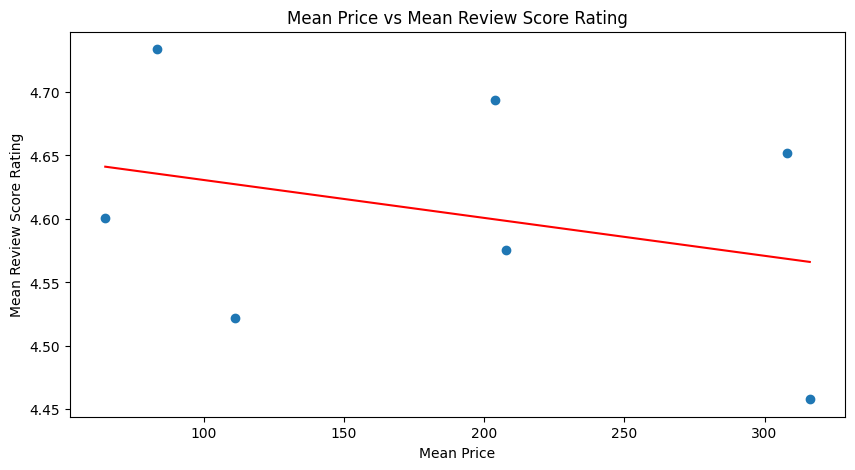

In [55]:
# Plotting the scatter plot of mean price vs mean review score rating along with the linear fit to visualize the correlation.
# The red line represents the best fit line obtained from the linear model.
plt.figure(figsize=(10, 5))
plt.scatter(mean_price_property.sort_index(), mean_review_score_property.sort_index())
plt.plot(mean_price_property, np.polyval(model, mean_price_property), 'r')
plt.xlabel('Mean Price')
plt.ylabel('Mean Review Score Rating')
plt.title('Mean Price vs Mean Review Score Rating')
plt.show()

#### 5. How do price and reviews vary in relation to the type of accommodation? Let's look at this analysis without removing the outliers.

It's essential to highlight that in this specific analysis, we chose not to remove price outliers. This means that the extremes of the price spectrum are included, which could potentially influence the correlation and linear regression results.

Including price outliers ensures that the analysis covers the entire range of the pricing landscape. While this approach offers insights into the complex dynamics between price and reviews, it also brings the risk of data noise and skewed interpretations.

The presence of outliers can impact the strength and reliability of the findings. It emphasizes the need for a careful review of the data and the potential effects of extreme values.

The analysis of mean prices and reviews based on property types unveils a nuanced landscape of guest accommodation experiences on Airbnb. A distinct variation is observed in the mean prices associated with different property types. The most affordable options, such as "Private room in home" and "Private room in condo," contrast sharply with the higher-end "Entire serviced apartment" and "Entire home." Interestingly, the review scores do not exhibit a direct correlation with the price. More affordable options like private rooms in condos or homes often receive higher review scores, suggesting guests might find better value in these accommodations.

A mild negative correlation of -0.3175 between price and review scores is revealed, indicating that as the price increases, the review scores tend to decrease, albeit not very strongly. This is further confirmed by the linear regression model characterized by the equation y = -2.98e-04x + 4.66. The negative slope indicates that for every unit increase in price, the review score is expected to decrease by this value, holding all else constant.

This dynamic has strategic implications for various stakeholders. For Airbnb, it can inform the refinement of recommendation algorithms to ensure guests find accommodations that align with their budget and expected experience. Property owners can focus on enhancing the value proposition of their listings, balancing price and quality to optimize both occupancy rates and reviews. Guests, on the other hand, can leverage this insight to make informed decisions, aligning their expectations with the price and type of accommodation.

In essence, while price is a pivotal factor, the guest experience, reflected in review scores, is not directly proportional to it. This underscores the multifaceted nature of guest satisfaction, where aspects beyond price play a significant role. A nuanced understanding of this relationship can foster enhanced strategies for pricing, amenities enhancement, and service quality, aligning with the diverse preferences of the Airbnb community.

In [56]:
# Displaying the count of each unique value in the 'host_response_time' column to understand the distribution of host response times.
df_listings['host_response_time'].value_counts()

host_response_time
within an hour        39089
within a few hours    11369
within a day           6591
a few days or more     1979
Name: count, dtype: int64

In [57]:
# Grouping the dataset by 'host_response_time' and calculating the mean review score for each response time category.
# This helps in understanding the impact of host's response time on the guest's review scores.
df_listings.groupby('host_response_time')['review_scores_rating'].mean().sort_values()

host_response_time
a few days or more    4.419764
within an hour        4.628174
within a day          4.694083
within a few hours    4.702548
Name: review_scores_rating, dtype: float64

In [58]:
# Filtering review_scores_rating data based on host_response_time
a_few_days_or_more = df_listings[df_listings['host_response_time'] == 'a few days or more']['review_scores_rating'].dropna()
within_an_hour = df_listings[df_listings['host_response_time'] == 'within an hour']['review_scores_rating'].dropna()
within_a_day = df_listings[df_listings['host_response_time'] == 'within a day']['review_scores_rating'].dropna()
within_a_few_hours = df_listings[df_listings['host_response_time'] == 'within a few hours']['review_scores_rating'].dropna()

# Performing the Kruskal-Wallis test
stat, p_value = kruskal(a_few_days_or_more, within_an_hour, within_a_day, within_a_few_hours)

# Printing the results
print(f"Test statistic: {stat}")
print(f"P-value: {p_value}")

# Setting the significance level
alpha = 0.05

# Determining whether to reject or fail to reject the null hypothesis
if p_value < alpha:
    print("We reject the null hypothesis. There is sufficient evidence to conclude that the host's response time significantly affects the review ratings.")
else:
    print("We fail to reject the null hypothesis. There is not enough evidence to conclude that the host's response time affects the review ratings.")

Test statistic: 654.119922314953
P-value: 1.8624935988611516e-141
We reject the null hypothesis. There is sufficient evidence to conclude that the host's response time significantly affects the review ratings.


Alright, moving in this direction.

#### 6. Are hosts who respond immediately (within an hour) statistically different in terms of review scores compared to those who respond within a day or within a few hours? 

I'm asking this because it appears that hosts who respond within an hour have a relatively lower review score.

Let's investigate.

In [59]:
# Filter the DataFrame based on the response time and extract the review scores
reviews_within_hour = df_listings[df_listings['host_response_time'] == 'within an hour']['review_scores_rating'].dropna()
reviews_within_day_or_few_hours = df_listings[df_listings['host_response_time'].isin(['within a day', 'within a few hours'])]['review_scores_rating'].dropna()

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(reviews_within_hour, reviews_within_day_or_few_hours, alternative='two-sided')

# Print the results
print(f"Test statistic: {stat}")
print(f"P-value: {p_value}")

# Set the significance level
alpha = 0.05

# Determine whether to reject the null hypothesis
if p_value < alpha:
    print("We reject the null hypothesis. There is a significant difference in review scores between the two groups of hosts.")
else:
    print("We fail to reject the null hypothesis. There is no significant difference in review scores between the two groups of hosts.")

Test statistic: 186492718.5
P-value: 2.9027533446975868e-142
We reject the null hypothesis. There is a significant difference in review scores between the two groups of hosts.


We can conduct a similar analysis to compare the review scores between hosts who respond within a few hours and those who respond within a day.

In [60]:
# Filter the DataFrame based on the specific response times and extract the review scores
reviews_within_few_hours = df_listings[df_listings['host_response_time'] == 'within a few hours']['review_scores_rating'].dropna()
reviews_within_day = df_listings[df_listings['host_response_time'] == 'within a day']['review_scores_rating'].dropna()

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(reviews_within_few_hours, reviews_within_day, alternative='two-sided')

# Print the results
print(f"Test statistic: {stat}")
print(f"P-value: {p_value}")

# Determine whether to reject the null hypothesis based on the p-value
if p_value < alpha:
    print("We reject the null hypothesis. There is a significant difference in review scores between hosts who respond within a few hours and those who respond within a day.")
else:
    print("We fail to reject the null hypothesis. There is no significant difference in review scores between the two groups of hosts.")

Test statistic: 21259757.5
P-value: 9.851642503033814e-05
We reject the null hypothesis. There is a significant difference in review scores between hosts who respond within a few hours and those who respond within a day.


In the pursuit of understanding the intricate dynamics between a host's response time and the subsequent review ratings they receive, a series of statistical tests were conducted. The objective was clear: to discern whether a statistical correlation exists and, if so, to what extent the speed of a host’s response influences the guest's review.

The initial step involved the application of the Kruskal-Wallis test, a non-parametric method used to evaluate whether there are statistically significant differences between two or more groups of an unpaired variable. The groups in question were defined by the host's response time: "a few days or more," "within an hour," "within a day," and "within a few hours." The result was intriguing. With a test statistic of 654.12 and a p-value approximating zero (1.86e-141), the null hypothesis was emphatically rejected. This outcome provides substantial evidence that the host's response time significantly affects the review ratings.

But how exactly does it affect them?

To delve deeper into this revelation, a Mann-Whitney U test was employed to compare hosts who respond "within an hour" to those responding "within a day" or "within a few hours." The test, which is particularly adept at handling non-normally distributed data, yielded another compelling result. A p-value of 2.90e-142 prompted the rejection of the null hypothesis, affirming a significant difference in review scores between the two groups of hosts.

Yet, a subsequent Mann-Whitney U test was conducted to contrast the review scores of hosts responding "within a few hours" and those responding "within a day." Despite the mean review scores being notably close, the test unveiled a p-value of 9.85e-05. This outcome, though initially counterintuitive, underscores that even closely aligned means can be statistically different due to the underlying distributions of the groups.

So, what does this all signify? This finding is particularly interesting as it suggests that the speed of response is a factor in the guest experience, influencing their perception of the host and the subsequent review ratings.

Of course, further investigations would be required to fully understand this phenomenon, perhaps through quasi-experiments or randomized experiments, but that is a topic for another time.

My intuition, recalling my days as a salesperson years ago, would tell me that you can't be too hasty in a sale, as this can push the customer away. But, on the other hand, you can't take too long to respond, as the customer might lose interest. I believe the same principle applies here. The balance in response time, not too quick to appear overeager and not too slow to seem uninterested, plays a pivotal role in shaping the guest's experience and their subsequent reviews.

In [61]:
# Displaying the descriptive statistics for the 'review_scores_location' column.
# This provides a summary of the central tendency, dispersion, and shape of the distribution of location review scores.
df_listings['review_scores_location'].describe()

count    64821.000000
mean         4.720487
std          0.421893
min          0.000000
25%          4.630000
50%          4.840000
75%          5.000000
max          5.000000
Name: review_scores_location, dtype: float64

London is renowned for being a city with extensive subway systems, so let's explore the words used in the descriptions of the listings to see if there is any insight with the location review scores.

To do this, we will compare listings that received a perfect score of 5 to those that received a score different from 5, and observe which words appear most frequently in each group.

In [62]:
# Creating two separate corpora of descriptions. 
# 'description_corpus_5_stars' contains descriptions from listings with a 5-star location rating, 
# while 'description_corpus_not_5_stars' contains descriptions from listings with a location rating less than 5.
# We're sampling 10,000 descriptions from each category to make the datasets manageable and comparable in size.
description_corpus_5_stars = ' '.join(df_listings[df_listings['review_scores_location'] == 5]['description'].dropna().sample(10_000).tolist())
description_corpus_not_5_stars = ' '.join(df_listings[df_listings['review_scores_location'] != 5]['description'].dropna().sample(10_000).tolist())

In [63]:
STOPWORDS.add('br')
STOPWORDS.add('b')

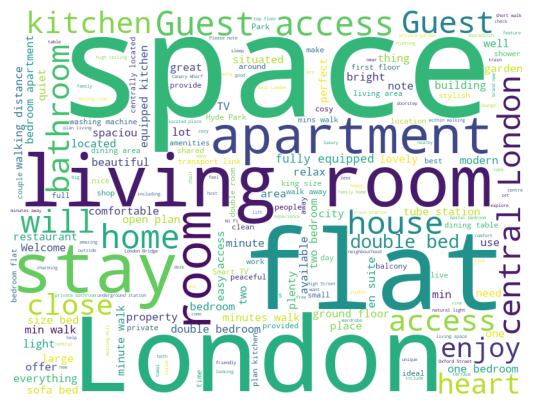

In [64]:
# Generating and plotting a word cloud for descriptions associated with 5-star location ratings.
# The word cloud visually represents the most frequently occurring words, with more common words appearing larger and bolder.
# We're using a white background and have specified the height and width of the word cloud image.
wc_5_star = WordCloud(stopwords=STOPWORDS, background_color='white', height=600, width=800).generate(description_corpus_5_stars)
plt.figure(figsize=(10, 5))
plt.imshow(wc_5_star)
plt.axis('off')
plt.show()

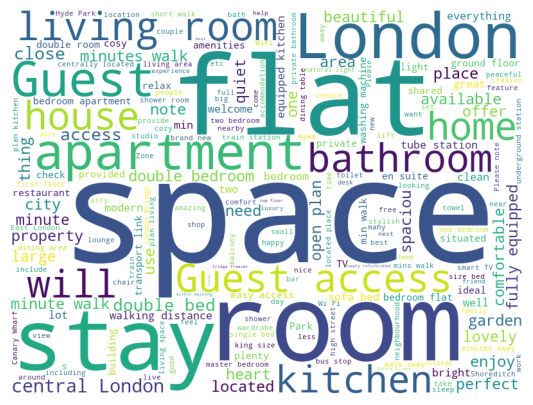

In [65]:
# Generating and plotting a word cloud for descriptions associated with location ratings less than 5 stars.
# This visualization helps to identify the most common words used in descriptions where the location rating is not perfect.
# Similar to the previous word cloud, common words are displayed larger and bolder.
wc_not_5_star = WordCloud(stopwords=STOPWORDS, background_color='white', height=600, width=800).generate(description_corpus_not_5_stars)
plt.figure(figsize=(10, 5))
plt.imshow(wc_not_5_star)
plt.axis('off')
plt.show()

In [66]:
# List of words you are interested in
words_of_interest = ['central', 'close']

# Create a count vectorizer with the words of interest as the vocabulary
vectorizer = CountVectorizer(vocabulary=words_of_interest)

# Apply the vectorizer to the datasets
word_counts_5_stars = vectorizer.transform([description_corpus_5_stars]).toarray()
word_counts_not_5_stars = vectorizer.transform([description_corpus_not_5_stars]).toarray()

# Print the counts for each dataset
print(f"Counts for 5 star reviews: {word_counts_5_stars}")
print(f"Counts for not 5 star reviews: {word_counts_not_5_stars}")

Counts for 5 star reviews: [[3442 2287]]
Counts for not 5 star reviews: [[3543 2463]]


In [67]:
# Remove stopwords and calculate the frequency of words for 5-star reviews
words_5_stars = nltk.word_tokenize(description_corpus_5_stars.lower())
words_5_stars = [word for word in words_5_stars if word not in stopwords.words('english') and word.isalpha()]
freq_dist_5_stars = FreqDist(words_5_stars)

# Print the 10 most common words
print("10 most common words in 5-star reviews:")
print(freq_dist_5_stars.most_common(10))

# Remove stopwords and calculate the frequency of words for reviews less than 5 stars
words_not_5_stars = nltk.word_tokenize(description_corpus_not_5_stars.lower())
words_not_5_stars = [word for word in words_not_5_stars if word not in stopwords.words('english') and word.isalpha()]
freq_dist_not_5_stars = FreqDist(words_not_5_stars)

# Print the 10 most common words
print("\n10 most common words in reviews less than 5 stars:")
print(freq_dist_not_5_stars.most_common(10))

10 most common words in 5-star reviews:
[('br', 73204), ('b', 10803), ('space', 9422), ('london', 8911), ('room', 8859), ('bedroom', 7242), ('flat', 7144), ('kitchen', 6774), ('walk', 6250), ('access', 6213)]

10 most common words in reviews less than 5 stars:
[('br', 75890), ('b', 11085), ('room', 9318), ('space', 9306), ('london', 8983), ('kitchen', 6802), ('bedroom', 6607), ('flat', 6523), ('access', 6268), ('apartment', 5912)]


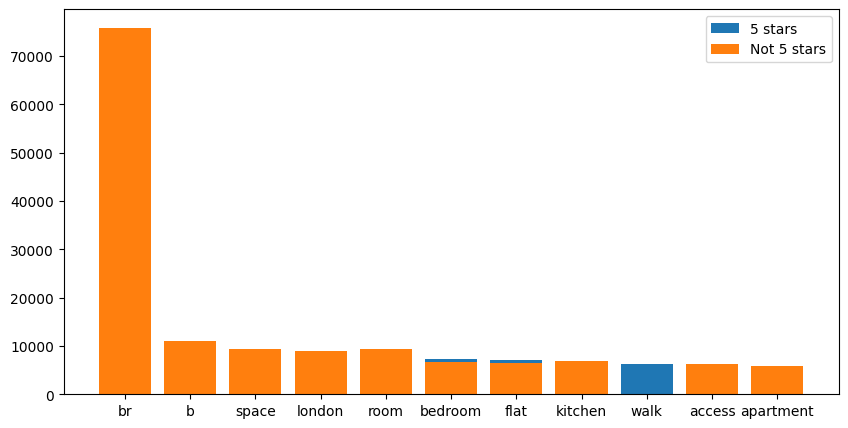

In [68]:
# plot freq_dist_5_stars.most_common(10) and freq_dist_not_5_stars.most_common(10) in the same plot
plt.figure(figsize=(10, 5))
plt.bar(*zip(*freq_dist_5_stars.most_common(10)), label='5 stars')
plt.bar(*zip(*freq_dist_not_5_stars.most_common(10)), label='Not 5 stars')
plt.legend()
plt.show()



#### 7. What are the most common words used in the descriptions of listings with a review score of 5 and those with a review score different from 5?

The analysis of the most common words yields subtle insights as they are somewhat similar in both frequency and order. We can observe that in the ranking of the top 10 words in 5-star reviews, 'bedroom' precedes 'kitchen', while the opposite is true for reviews with less than 5 stars. There is also a close number of words in each group. However, since we are using a 'bag of words' approach where the order and semantic context of words are not captured, we cannot assert that the words carry the same meaning, only that they are the same words.

For the following analysis, I employed the code below:

```python
import ast
import pandas as pd
from transformers import pipeline
import concurrent.futures
import pickle

# Reading the DataFrame
df_listings = pd.read_csv('data/listings.csv')

# Extracting all unique amenities
all_amenities = set()
for amenities in df_listings['amenities']:
    for amenity in ast.literal_eval(amenities):
        all_amenities.add(amenity.strip(' '))

# Initializing the zero-shot classification pipeline
# zero_shot = pipeline("zero-shot-classification",
#                      candidate_labels=["TV", "WiFi", "Personal Care", 
#                                        "Appliances", "Audio Equipment", 
#                                        "Pools", "Furniture", "Home Accessories", "Others"],
#                      model="facebook/bart-large-mnli")

zero_shot = pipeline("zero-shot-classification",
                     candidate_labels=[
                         "Small-Medium TV", "Large TV", "WiFi", "Fast WiFi", 
                         "Personal Care Products", 
                         "Standard Kitchen and Appliances", 
                         "Gourmet Kitchen and Appliances", "Audio Equipment", 
                         "Premium Audio Equipment",
                         "Private Pool", "Shared pool", "Furniture", "Home Accessories", 
                         "Views and Location", "Parking", 
                         "Exercise Equipment and Fitness Facilities", 
                         "Security", "Children Amenities", 
                         "Outdoor and Recreation", "Other Services", 
                         "Accessibility"
                     ],
                     model="facebook/bart-large-mnli")

# Function to classify amenities
def zero_shot_classification(amenity):
    result = zero_shot(amenity)
    return amenity, result['labels'][0]

# Dictionary to store the classification results
amenities_classification = {}

# Using concurrent.futures for parallel classification
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(zero_shot_classification, all_amenities))

# Populating the dictionary with the results
for amenity, label in results:
    amenities_classification[amenity] = label

# Saving the dictionary to a pickle file
with open('amenities_classification.pkl', 'wb') as f:
    pickle.dump(amenities_classification, f)

print("Dictionary saved in 'amenities_classification.pkl'")

```

Given that this code takes a considerable amount of time to execute, I saved the result in a pickle file and loaded it here.


In [69]:
# Load pickle file
with open('data/amenities_classification.pkl', 'rb') as f:
    amenities_classification = pickle.load(f)

In [70]:
# Printing the first 15 amenities classified as 'Fast WiFi' from the amenities_classification dictionary.
# This code snippet is useful for quickly inspecting specific examples of amenities labeled as 'Fast WiFi'.
i = 0  # Initializing a counter to keep track of the number of printed amenities
for amenity, label in amenities_classification.items():  # Iterating through the dictionary of amenities and their classifications
    if label == 'Fast WiFi':  # Checking if the current amenity is classified as 'Fast WiFi'
        print(amenity)  # Printing the amenity
        i += 1  # Incrementing the counter
    if i == 15:  # Checking if 15 amenities have been printed
        break  # Exiting the loop if 15 amenities have been printed


Fast wifi – 103 Mbps
Fast wifi – 343 Mbps
Fast wifi – 507 Mbps
Fast wifi – 84 Mbps
Fast wifi – 526 Mbps
Fast wifi – 92 Mbps
Fast wifi – 270 Mbps
Fast wifi – 853 Mbps
Fast wifi – 206 Mbps
Fast wifi – 645 Mbps
Fast wifi – 102 Mbps
Fast wifi – 429 Mbps
Fast wifi – 454 Mbps
Fast wifi – 359 Mbps
Fast wifi – 371 Mbps


In [71]:
# Printing the first 15 amenities classified as 'WiFi' from the amenities_classification dictionary.
# This code snippet is useful for quickly inspecting specific examples of amenities labeled as 'WiFi'.
# A counter 'i' is initialized to keep track of the number of printed amenities.
# The code then iterates through the dictionary of amenities and their classifications.
# Each amenity labeled as 'WiFi' is printed, and the counter is incremented.
# The loop breaks after 15 amenities labeled as 'WiFi' have been printed to limit the output.
i = 0  # Initializing a counter to keep track of the number of printed amenities
for amenity, label in amenities_classification.items():  # Iterating through the dictionary of amenities and their classifications
    if label == 'WiFi':  # Checking if the current amenity is classified as 'WiFi'
        print(amenity)  # Printing the amenity
        i += 1  # Incrementing the counter
    if i == 15:  # Checking if 15 amenities have been printed
        break  # Exiting the loop if 15 amenities have been printed

Wifi – 18 Mbps
Wifi – 1 Mbps
Wifi – 12 Mbps
Wifi – 15 Mbps
Wifi – 0 Mbps
Wifi – 22 Mbps
With frezee  refrigerator
Wifi – 27 Mbps
Fiils conditioner
Wifi – 28 Mbps
Wifi – 20 Mbps
Wifi – 39 Mbps
Sonos- Wi-Fi  sound system
Wifi – 40 Mbps
Wifi – 6 Mbps


In [72]:
# Creating a filtered dictionary 'amenities_classification_filtered' to only include specific types of amenities.
# The dictionary comprehension iterates through the 'amenities_classification' dictionary.
# It includes an amenity in the filtered dictionary if its label is one of the specified types: "Small-Medium TV", "Large TV", "WiFi", "Fast WiFi", "Private Pool", or "Shared pool".
# This filtered dictionary can be used for focused analysis on these selected types of amenities.
amenities_classification_filtered = {amenity: label for amenity, label in amenities_classification.items() if label in ["Small-Medium TV", "Large TV", "WiFi", "Fast WiFi", "Private Pool", "Shared pool"]}

In [73]:
# Assigning the filtered amenities dictionary back to the original 'amenities_classification' variable.
# This step is necessary to update the 'amenities_classification' variable with only the selected types of amenities for further analysis.
amenities_classification = amenities_classification_filtered

Alright, we can observe that our attempt seems fairly adequate; we have one category with fast WiFi and another with standard WiFi. We aim to implement a quasi-experiment to determine if hosts offering fast WiFi can increase the price of their listing. To do this, we will compare listings that offer fast WiFi with those offering standard WiFi to see if there is any difference in price.

Of course, we are conducting this on a surface level. A more in-depth analysis would require a comprehensive study, but that's a topic for another time.

The plan is to conduct a one-to-one experiment, selecting specific variables and looking for close pairs to compare. We will use the Euclidean distance method and seek only the nearest match.

In [74]:
# Converting the 'amenities' column from string format to a list of amenities using the 'ast.literal_eval' method.
# This step is essential to transform the amenities data into a usable format for further processing and analysis.
df_amenities_list = df_listings['amenities'].apply(ast.literal_eval)

In [75]:
df_amenities_list.head()

0    [Heating, TV with standard cable, Wifi, Smoke ...
1    [Window guards, Bathtub, Hot water kettle, Lau...
2    [Bathtub, Hot water kettle, Laundromat nearby,...
3    [Shampoo, Luggage dropoff allowed, Dryer, Micr...
4    [Window guards, Bathtub, Hot water kettle, Lau...
Name: amenities, dtype: object

In [76]:
# Defining a function to categorize amenities based on the predefined 'amenities_classification' dictionary.
# The function takes a list of amenities and returns a new list with the amenities categorized.
# If an amenity is not found in the 'amenities_classification' dictionary, it is categorized as 'Other'.
def new_category(amenity_list):
    new_amenity_list = []
    for amenity in amenity_list:
        if amenity in amenities_classification.keys():
            new_amenity_list.append(amenities_classification[amenity])
        else:
            new_amenity_list.append('Other')
    return new_amenity_list

In [77]:
# Applying the 'new_category' function to each row in the 'df_amenities_list' DataFrame.
# This will transform the original list of amenities into a new list where each amenity is categorized according to the 'amenities_classification' dictionary.
df_amenities_list = df_amenities_list.apply(new_category)

In [78]:
# Displaying the first few rows of the DataFrame df_amenities_list to inspect the transformed amenities data
df_amenities_list.head()

0    [Small-Medium TV, Small-Medium TV, WiFi, Small...
1    [Other, Other, Other, Other, Other, Other, Oth...
2    [Other, Other, Other, Other, Other, Other, Oth...
3    [Other, Other, Small-Medium TV, Other, Other, ...
4    [Other, Other, Other, Other, Other, Other, Oth...
Name: amenities, dtype: object

In [79]:
def extract_wifi(amenities_list):
    if 'WiFi' in amenities_list:
        return 'WiFi'
    elif 'Fast WiFi' in amenities_list:
        return 'Fast WiFi'
    else:
        return np.nan
    

In [80]:
# Extracting Wi-Fi related amenities from the df_amenities_list DataFrame
df_wifi_amenities = df_amenities_list.apply(extract_wifi)

In [81]:
# Counting the occurrences of each Wi-Fi related amenity in the df_wifi_amenities DataFrame
df_wifi_amenities.value_counts()

amenities
WiFi         80896
Fast WiFi     3616
Name: count, dtype: int64

In [82]:
# Adding the Wi-Fi amenities information to the original df_listings DataFrame
df_listings['wifi_amenities'] = df_wifi_amenities

In [83]:
# Define a function to extract TV amenity information from a list of amenities
def extract_tv(amenities_list):
    if 'Small-Medium TV' in amenities_list:
        return 'Small-Medium TV'
    elif 'Large TV' in amenities_list:
        return 'Large TV'
    else:
        return np.nan

In [84]:
# Applying the extract_tv function to the df_amenities_list DataFrame to create a new column 'tv_amenities'
df_tv_amenities = df_amenities_list.apply(extract_tv)

In [85]:
# Counting the occurrences of each TV amenity category in the 'tv_amenities' column
df_tv_amenities.value_counts()

amenities
Small-Medium TV    84724
Large TV              78
Name: count, dtype: int64

In [86]:
# Adding the 'tv_amenities' column to the DataFrame 'df_listings'
df_listings['tv_amenities'] = df_tv_amenities

In [87]:
# Defining a function to extract pool-related amenities from a list of amenities
def extract_pool(amenities_list):
    if 'Private Pool' in amenities_list:
        return 'Private Pool'
    elif 'Shared pool' in amenities_list:
        return 'Shared pool'
    else:
        return np.nan

In [88]:
# Applying the 'extract_pool' function to extract pool-related amenities from the DataFrame
df_pool_amenities = df_amenities_list.apply(extract_pool)
# Counting the occurrences of each type of pool-related amenity and displaying the counts
df_pool_amenities.value_counts()

amenities
Shared pool     72618
Private Pool      218
Name: count, dtype: int64

In [89]:
# Assigning the extracted pool-related amenities to the 'pool_amenities' column in the DataFrame 'df_listings'
df_listings['pool_amenities'] = df_pool_amenities

In [90]:
compare_columns = ['host_is_superhost', 'neighbourhood_cleansed', 'property_type',
 'room_type', 'accommodates']

#### TV

In [91]:
# Creating a DataFrame for comparing specific columns along with 'tv_amenities'
df_tv_amenities_compare = df_listings[compare_columns + ['tv_amenities']].dropna()
# Counting the values in the 'tv_amenities' column to understand the distribution of TV-related amenities
df_tv_amenities_compare['tv_amenities'].value_counts()

tv_amenities
Small-Medium TV    83805
Large TV              77
Name: count, dtype: int64

In [92]:
# Creating dummy variables for categorical columns in the DataFrame 'df_tv_amenities_compare'
# 'drop_first=True' is used to avoid multicollinearity by dropping the first category in each categorical variable
df_tv_amenities_compare_dummy = pd.get_dummies(df_tv_amenities_compare, drop_first=True)

In [93]:
# Showing the first few rows of the DataFrame 'df_tv_amenities_compare_dummy' to inspect the dummy variables
df_tv_amenities_compare_dummy[df_tv_amenities_compare_dummy['tv_amenities_Small-Medium TV'] == 0].head()

,accommodates,host_is_superhost_t,neighbourhood_cleansed_Barnet,neighbourhood_cleansed_Bexley,neighbourhood_cleansed_Brent,neighbourhood_cleansed_Bromley,neighbourhood_cleansed_Camden,neighbourhood_cleansed_City of London,neighbourhood_cleansed_Croydon,neighbourhood_cleansed_Ealing,neighbourhood_cleansed_Enfield,neighbourhood_cleansed_Greenwich,neighbourhood_cleansed_Hackney,neighbourhood_cleansed_Hammersmith and Fulham,neighbourhood_cleansed_Haringey,neighbourhood_cleansed_Harrow,neighbourhood_cleansed_Havering,neighbourhood_cleansed_Hillingdon,neighbourhood_cleansed_Hounslow,neighbourhood_cleansed_Islington,neighbourhood_cleansed_Kensington and Chelsea,neighbourhood_cleansed_Kingston upon Thames,neighbourhood_cleansed_Lambeth,neighbourhood_cleansed_Lewisham,neighbourhood_cleansed_Merton,neighbourhood_cleansed_Newham,neighbourhood_cleansed_Redbridge,neighbourhood_cleansed_Richmond upon Thames,neighbourhood_cleansed_Southwark,neighbourhood_cleansed_Sutton,neighbourhood_cleansed_Tower Hamlets,neighbourhood_cleansed_Waltham Forest,neighbourhood_cleansed_Wandsworth,neighbourhood_cleansed_Westminster,property_type_Boat,property_type_Camper/RV,property_type_Campsite,property_type_Casa particular,property_type_Castle,property_type_Dome,property_type_Earthen home,property_type_Entire bungalow,property_type_Entire cabin,property_type_Entire chalet,property_type_Entire condo,property_type_Entire cottage,property_type_Entire guest suite,property_type_Entire guesthouse,property_type_Entire home,property_type_Entire home/apt,property_type_Entire loft,property_type_Entire place,property_type_Entire rental unit,property_type_Entire serviced apartment,property_type_Entire townhouse,property_type_Entire vacation home,property_type_Entire villa,property_type_Farm stay,property_type_Floor,property_type_Houseboat,property_type_Hut,property_type_Island,property_type_Minsu,property_type_Private room,property_type_Private room in bed and breakfast,property_type_Private room in boat,property_type_Private room in bungalow,property_type_Private room in cabin,property_type_Private room in camper/rv,property_type_Private room in casa particular,property_type_Private room in castle,property_type_Private room in cave,property_type_Private room in chalet,property_type_Private room in condo,property_type_Private room in cottage,property_type_Private room in earthen home,property_type_Private room in farm stay,property_type_Private room in floor,property_type_Private room in guest suite,property_type_Private room in guesthouse,property_type_Private room in home,property_type_Private room in hostel,property_type_Private room in houseboat,property_type_Private room in hut,property_type_Private room in island,property_type_Private room in lighthouse,property_type_Private room in loft,property_type_Private room in nature lodge,property_type_Private room in religious building,property_type_Private room in rental unit,property_type_Private room in serviced apartment,property_type_Private room in shepherd's hut,property_type_Private room in tiny home,property_type_Private room in townhouse,property_type_Private room in treehouse,property_type_Private room in vacation home,property_type_Private room in villa,property_type_Private room in yurt,property_type_Religious building,property_type_Riad,property_type_Room in aparthotel,property_type_Room in bed and breakfast,property_type_Room in boutique hotel,property_type_Room in hostel,property_type_Room in hotel,property_type_Room in rental unit,property_type_Room in serviced apartment,property_type_Shared room,property_type_Shared room in bed and breakfast,property_type_Shared room in boutique hotel,property_type_Shared room in bungalow,property_type_Shared room in bus,property_type_Shared room in condo,property_type_Shared room in earthen home,property_type_Shared room in farm stay,property_type_Shared room in guest suite,property_type_Shared room in guesthouse,property_type_Shared room in home,property_type_Shared roo

From the dataset above, we will randomly select 40 entries, and then search for the closest match where the column 'tv_amenities_Small-Medium TV' equals 1.

In [94]:
# seed
np.random.seed(1)
sample_40_tv_large = df_tv_amenities_compare_dummy[df_tv_amenities_compare_dummy['tv_amenities_Small-Medium TV'] == 0].sample(40)
all_tv_small_medium = df_tv_amenities_compare_dummy[df_tv_amenities_compare_dummy['tv_amenities_Small-Medium TV'] == 1]

In [95]:
# Initialize the list of pairs
pairs = []
for row in sample_40_tv_large.iterrows():
    big_tv = row[1].drop('tv_amenities_Small-Medium TV')
    index_big_tv = row[0]
    minimal_distance = np.inf
    index_small_tv = None  # Initialize the index_small_tv variable
    for row in all_tv_small_medium.iterrows():
        small_tv = row[1].drop('tv_amenities_Small-Medium TV')
        temp_index_small_tv = row[0]  # Use a temporary variable to store the current index
        distance_value = distance.euclidean(big_tv.values, small_tv.values)
        if distance_value < minimal_distance:
            minimal_distance = distance_value
            index_small_tv = temp_index_small_tv  # Update the index_small_tv variable when a smaller distance is found
            if minimal_distance == 0:
                break  # If the minimal distance is 0, we can break the loop early as we can't find a closer match
    pairs.append((index_big_tv, index_small_tv, minimal_distance))  # Append the pair with the minimal distance found


In [96]:
# Showing the last 5 pairs
pairs[-5:]

[(70160, 630, 0.0),
 (62169, 17022, 0.0),
 (64812, 423, 0.0),
 (56287, 32052, 0.0),
 (46382, 160, 0.0)]

In [97]:
# Showing an example of a pair with a distance of 0
df_listings.loc[46382][compare_columns + ['price']]

host_is_superhost                       f
neighbourhood_cleansed      Tower Hamlets
property_type                Entire condo
room_type                 Entire home/apt
accommodates                            2
price                               110.0
Name: 46382, dtype: object

In [98]:
# Showing an example of a pair with a distance greater than 0
df_listings.loc[160][compare_columns + ['price']]

host_is_superhost                       f
neighbourhood_cleansed      Tower Hamlets
property_type                Entire condo
room_type                 Entire home/apt
accommodates                            2
price                               111.0
Name: 160, dtype: object

In [99]:
# Calculating the average price of listings with a large TV and the average price of listings with a small-medium TV
sum_large_tv = 0
sum_small_tv = 0
total = 0
for pair in pairs:
    if pair[2] == 0:
        sum_large_tv += df_listings.loc[pair[0]]['price']
        sum_small_tv += df_listings.loc[pair[1]]['price']
        total += 1

In [100]:
# Calculating the average price for each type of TV
sum_large_tv / total, sum_small_tv / total

(149.94594594594594, 128.0)

In [101]:
# Calculating the difference in average price between listings with a large TV and listings with a small-medium TV
sum_large_tv / total - sum_small_tv / total

21.945945945945937

In [102]:
# Initial and final values
initial_value = sum_small_tv / total
final_value = sum_large_tv / total

# Calculating the percentage gain
percentage_gain = ((final_value - initial_value) / initial_value) * 100

# Displaying the result
print(f'The percentage gain is {percentage_gain:.2f}%')

The percentage gain is 17.15%


#### 8. Is there a difference in the price of listings that offer Large TV compared to those that offer Small-Medium TV?

When comparing listings that feature a Large TV to those equipped with a Small or Medium TV, we can observe a discernible difference in pricing. For the sake of simplicity in this analysis (acknowledging that a more in-depth examination could be conducted), I’m adopting a non-model-dependent approach inspired by Gary King. He posits that when dealing with paired groups, even a simple average can serve as a meaningful indicator.

Adhering to this principle, it becomes evident that hosts who upgrade their TV amenities could potentially increase their earnings. Specifically, enhancing the quality or size of the TV could translate to an additional revenue of approximately $21.94 per booking day. This insight, although derived from a basic comparative analysis, underscores the potential financial benefits of improving in-property entertainment amenities for hosts.

#### WiFi

In [103]:
# Creating a DataFrame for comparing specific columns along with 'wifi_amenities'
df_wifi_amenities_compare = df_listings[compare_columns + ['wifi_amenities']].dropna()
df_wifi_amenities_compare['wifi_amenities'].value_counts()

wifi_amenities
WiFi         80022
Fast WiFi     3571
Name: count, dtype: int64

In [104]:
# Creating dummy variables for categorical columns in the DataFrame 'df_wifi_amenities_compare'
df_wifi_amenities_compare_dummy = pd.get_dummies(df_wifi_amenities_compare, drop_first=True)

In [105]:
# Showing the first few rows of the DataFrame 'df_wifi_amenities_compare_dummy' to inspect the dummy variables
df_wifi_amenities_compare_dummy.head()

,accommodates,host_is_superhost_t,neighbourhood_cleansed_Barnet,neighbourhood_cleansed_Bexley,neighbourhood_cleansed_Brent,neighbourhood_cleansed_Bromley,neighbourhood_cleansed_Camden,neighbourhood_cleansed_City of London,neighbourhood_cleansed_Croydon,neighbourhood_cleansed_Ealing,neighbourhood_cleansed_Enfield,neighbourhood_cleansed_Greenwich,neighbourhood_cleansed_Hackney,neighbourhood_cleansed_Hammersmith and Fulham,neighbourhood_cleansed_Haringey,neighbourhood_cleansed_Harrow,neighbourhood_cleansed_Havering,neighbourhood_cleansed_Hillingdon,neighbourhood_cleansed_Hounslow,neighbourhood_cleansed_Islington,neighbourhood_cleansed_Kensington and Chelsea,neighbourhood_cleansed_Kingston upon Thames,neighbourhood_cleansed_Lambeth,neighbourhood_cleansed_Lewisham,neighbourhood_cleansed_Merton,neighbourhood_cleansed_Newham,neighbourhood_cleansed_Redbridge,neighbourhood_cleansed_Richmond upon Thames,neighbourhood_cleansed_Southwark,neighbourhood_cleansed_Sutton,neighbourhood_cleansed_Tower Hamlets,neighbourhood_cleansed_Waltham Forest,neighbourhood_cleansed_Wandsworth,neighbourhood_cleansed_Westminster,property_type_Boat,property_type_Camper/RV,property_type_Campsite,property_type_Casa particular,property_type_Castle,property_type_Dome,property_type_Earthen home,property_type_Entire bungalow,property_type_Entire cabin,property_type_Entire chalet,property_type_Entire condo,property_type_Entire cottage,property_type_Entire guest suite,property_type_Entire guesthouse,property_type_Entire home,property_type_Entire home/apt,property_type_Entire loft,property_type_Entire place,property_type_Entire rental unit,property_type_Entire serviced apartment,property_type_Entire townhouse,property_type_Entire vacation home,property_type_Entire villa,property_type_Floor,property_type_Houseboat,property_type_Hut,property_type_Island,property_type_Minsu,property_type_Private room,property_type_Private room in bed and breakfast,property_type_Private room in boat,property_type_Private room in bungalow,property_type_Private room in cabin,property_type_Private room in casa particular,property_type_Private room in castle,property_type_Private room in cave,property_type_Private room in chalet,property_type_Private room in condo,property_type_Private room in cottage,property_type_Private room in earthen home,property_type_Private room in farm stay,property_type_Private room in floor,property_type_Private room in guest suite,property_type_Private room in guesthouse,property_type_Private room in home,property_type_Private room in hostel,property_type_Private room in houseboat,property_type_Private room in hut,property_type_Private room in island,property_type_Private room in lighthouse,property_type_Private room in loft,property_type_Private room in nature lodge,property_type_Private room in religious building,property_type_Private room in rental unit,property_type_Private room in serviced apartment,property_type_Private room in shepherd's hut,property_type_Private room in tiny home,property_type_Private room in townhouse,property_type_Private room in treehouse,property_type_Private room in vacation home,property_type_Private room in villa,property_type_Private room in yurt,property_type_Religious building,property_type_Riad,property_type_Room in aparthotel,property_type_Room in bed and breakfast,property_type_Room in boutique hotel,property_type_Room in hostel,property_type_Room in hotel,property_type_Room in rental unit,property_type_Room in serviced apartment,property_type_Shared room,property_type_Shared room in bed and breakfast,property_type_Shared room in boutique hotel,property_type_Shared room in bungalow,property_type_Shared room in condo,property_type_Shared room in earthen home,property_type_Shared room in farm stay,property_type_Shared room in guesthouse,property_type_Shared room in home,property_type_Shared room in hostel,property_type_Shared room in hotel,property_type_Shared room in loft,property_type_Shared room in religious building,property_

From the dataset above, we will randomly select 30 entries, and then search for the closest match where the column 

In [106]:
# seed
np.random.seed(1)
sample_40_wifi_fast = df_wifi_amenities_compare_dummy[df_wifi_amenities_compare_dummy['wifi_amenities_WiFi'] == 0].sample(40)
all_wifi = df_wifi_amenities_compare_dummy[df_wifi_amenities_compare_dummy['wifi_amenities_WiFi'] == 1]

In [107]:
# Initialize the list of pairs
pairs = []
for row in sample_40_wifi_fast.iterrows():
    fast_wifi = row[1].drop('wifi_amenities_WiFi')
    index_fast_wifi = row[0]
    minimal_distance = np.inf
    index_wifi = None  # Initialize the index_small_tv variable
    for row in all_wifi.iterrows():
        wifi = row[1].drop('wifi_amenities_WiFi')
        temp_index_wifi = row[0]  # Use a temporary variable to store the current index
        distance_value = distance.euclidean(fast_wifi.values, wifi.values)
        if distance_value < minimal_distance:
            minimal_distance = distance_value
            index_wifi = temp_index_wifi  # Update the index_small_tv variable when a smaller distance is found
            if minimal_distance == 0:
                break  # If the minimal distance is 0, we can break the loop early as we can't find a closer match
    pairs.append((index_fast_wifi, index_wifi, minimal_distance))  # Append the pair with the minimal distance found

In [108]:
# Showing the last 5 pairs
pairs[-5:]

[(84235, 56816, 0.0),
 (68378, 1611, 0.0),
 (73979, 13147, 0.0),
 (75693, 1969, 0.0),
 (61285, 575, 0.0)]

In [109]:
# Calculating the average price of listings with fast Wi-Fi and the average price of listings with Wi-Fi
sum_fast_wifi = 0
sum_wifi = 0
total = 0
for pair in pairs:
    if pair[2] == 0:
        sum_fast_wifi += df_listings.loc[pair[0]]['price']
        sum_wifi += df_listings.loc[pair[1]]['price']
        total += 1

In [110]:
# Calculating the average price for each type of Wi-Fi
sum_fast_wifi / total, sum_wifi / total

(187.56410256410257, 163.76923076923077)

In [111]:
# Calculating the difference in average price between listings with fast Wi-Fi and listings with Wi-Fi
sum_fast_wifi / total - sum_wifi / total

23.794871794871796

In [112]:
# Initial and final values
initial_value = sum_wifi / total
final_value = sum_fast_wifi / total

# Calculating the percentage gain
percentage_gain = ((final_value - initial_value) / initial_value) * 100

# Displaying the result
print(f'The percentage gain is {percentage_gain:.2f}%')

The percentage gain is 14.53%


In [113]:
total

39

#### 9. Is there a difference in the price of listings that offer fast WiFi compared to those that offer standard WiFi?

In the context of WiFi quality, a comparative analysis reveals a noticeable difference in the pricing of listings. By dividing the total earnings by the total variable, we derive an average daily earning for listings with different types of WiFi. Listings offering fast WiFi have an average daily earning of approximately $187.56, while those with standard WiFi earn around $163.76 per day on average.

This observation suggests that enhancing the WiFi quality could potentially lead to an increase in daily earnings for the hosts. The data indicates a clear financial incentive to improve internet connectivity, with listings offering fast WiFi earning more on average than those with standard WiFi. This underscores the value guests place on high-speed internet access during their stay.

#### Pool

In [114]:
# Creating a DataFrame for comparing specific columns along with 'pool_amenities'
df_pool_amenities_compare = df_listings[compare_columns + ['pool_amenities']].dropna()
df_pool_amenities_compare['pool_amenities'].value_counts()

pool_amenities
Shared pool     71745
Private Pool      215
Name: count, dtype: int64

In [115]:
# Creating dummy variables for categorical columns in the DataFrame 'df_pool_amenities_compare'
df_pool_amenities_compare_dummy = pd.get_dummies(df_pool_amenities_compare, drop_first=True)
df_pool_amenities_compare_dummy.head()

,accommodates,host_is_superhost_t,neighbourhood_cleansed_Barnet,neighbourhood_cleansed_Bexley,neighbourhood_cleansed_Brent,neighbourhood_cleansed_Bromley,neighbourhood_cleansed_Camden,neighbourhood_cleansed_City of London,neighbourhood_cleansed_Croydon,neighbourhood_cleansed_Ealing,neighbourhood_cleansed_Enfield,neighbourhood_cleansed_Greenwich,neighbourhood_cleansed_Hackney,neighbourhood_cleansed_Hammersmith and Fulham,neighbourhood_cleansed_Haringey,neighbourhood_cleansed_Harrow,neighbourhood_cleansed_Havering,neighbourhood_cleansed_Hillingdon,neighbourhood_cleansed_Hounslow,neighbourhood_cleansed_Islington,neighbourhood_cleansed_Kensington and Chelsea,neighbourhood_cleansed_Kingston upon Thames,neighbourhood_cleansed_Lambeth,neighbourhood_cleansed_Lewisham,neighbourhood_cleansed_Merton,neighbourhood_cleansed_Newham,neighbourhood_cleansed_Redbridge,neighbourhood_cleansed_Richmond upon Thames,neighbourhood_cleansed_Southwark,neighbourhood_cleansed_Sutton,neighbourhood_cleansed_Tower Hamlets,neighbourhood_cleansed_Waltham Forest,neighbourhood_cleansed_Wandsworth,neighbourhood_cleansed_Westminster,property_type_Boat,property_type_Camper/RV,property_type_Campsite,property_type_Casa particular,property_type_Castle,property_type_Dome,property_type_Earthen home,property_type_Entire bungalow,property_type_Entire cabin,property_type_Entire chalet,property_type_Entire condo,property_type_Entire cottage,property_type_Entire guest suite,property_type_Entire guesthouse,property_type_Entire home,property_type_Entire home/apt,property_type_Entire loft,property_type_Entire place,property_type_Entire rental unit,property_type_Entire serviced apartment,property_type_Entire townhouse,property_type_Entire vacation home,property_type_Entire villa,property_type_Farm stay,property_type_Floor,property_type_Houseboat,property_type_Hut,property_type_Island,property_type_Minsu,property_type_Private room,property_type_Private room in bed and breakfast,property_type_Private room in boat,property_type_Private room in bungalow,property_type_Private room in cabin,property_type_Private room in casa particular,property_type_Private room in castle,property_type_Private room in chalet,property_type_Private room in condo,property_type_Private room in cottage,property_type_Private room in earthen home,property_type_Private room in farm stay,property_type_Private room in floor,property_type_Private room in guest suite,property_type_Private room in guesthouse,property_type_Private room in home,property_type_Private room in hostel,property_type_Private room in houseboat,property_type_Private room in hut,property_type_Private room in island,property_type_Private room in lighthouse,property_type_Private room in loft,property_type_Private room in nature lodge,property_type_Private room in rental unit,property_type_Private room in serviced apartment,property_type_Private room in shepherd's hut,property_type_Private room in tiny home,property_type_Private room in townhouse,property_type_Private room in treehouse,property_type_Private room in vacation home,property_type_Private room in villa,property_type_Private room in yurt,property_type_Religious building,property_type_Riad,property_type_Room in aparthotel,property_type_Room in bed and breakfast,property_type_Room in boutique hotel,property_type_Room in hostel,property_type_Room in hotel,property_type_Room in rental unit,property_type_Room in serviced apartment,property_type_Shared room,property_type_Shared room in bed and breakfast,property_type_Shared room in bungalow,property_type_Shared room in condo,property_type_Shared room in farm stay,property_type_Shared room in guest suite,property_type_Shared room in guesthouse,property_type_Shared room in home,property_type_Shared room in hostel,property_type_Shared room in hotel,property_type_Shared room in loft,property_type_Shared room in rental unit,property_type_Shared room in serviced apartment,property_type_Shared room in tent,property_type_Shared room in townhouse,

From the dataset above, we will randomly select 40 entries, and then search for the closest match.

In [116]:
np.random.seed(1)
sample_40_private = df_pool_amenities_compare_dummy[df_pool_amenities_compare_dummy['pool_amenities_Shared pool'] == 0].sample(40)
all_shared = df_pool_amenities_compare_dummy[df_pool_amenities_compare_dummy['pool_amenities_Shared pool'] == 1]

In [117]:
# Initialize the list of pairs
pairs = []
for row in sample_40_private.iterrows():
    private = row[1].drop('pool_amenities_Shared pool')
    index_private = row[0]
    minimal_distance = np.inf
    index_shared = None  # Initialize the index_small_tv variable
    for row in all_shared.iterrows():
        shared = row[1].drop('pool_amenities_Shared pool')
        temp_index_shared = row[0]  # Use a temporary variable to store the current index
        distance_value = distance.euclidean(private.values, shared.values)
        if distance_value < minimal_distance:
            minimal_distance = distance_value
            index_shared = temp_index_shared  # Update the index_small_tv variable when a smaller distance is found
            if minimal_distance == 0:
                break  # If the minimal distance is 0, we can break the loop early as we can't find a closer match
    pairs.append((index_private, index_shared, minimal_distance))  # Append the pair with the minimal distance found

In [118]:
# Showing the last 5 pairs
pairs[-5:]

[(2497, 84932, 0.0),
 (71995, 65967, 0.0),
 (69417, 617, 0.0),
 (66205, 311, 0.0),
 (43085, 45198, 0.0)]

In [119]:
# Calculating the average price of listings with a private pool and the average price of listings with a shared pool
sum_private = 0
sum_shared = 0
total = 0
for pair in pairs:
    if pair[2] == 0:
        sum_private += df_listings.loc[pair[0]]['price']
        sum_shared += df_listings.loc[pair[1]]['price']
        total += 1

In [120]:
# Calculating the average price for each type of pool
sum_private / total, sum_shared / total

(351.46153846153845, 177.5897435897436)

In [121]:
# Calculating the difference in average price between listings with a private pool and listings with a shared pool
sum_private / total - sum_shared / total

173.87179487179486

In [122]:
# Initial and final values
initial_value = sum_shared / total
final_value = sum_private / total

# Calculating the percentage gain
percentage_gain = ((final_value - initial_value) / initial_value) * 100

# Displaying the result
print(f'The percentage gain is {percentage_gain:.2f}%')

The percentage gain is 97.91%


#### 10. Is there a difference in the price of listings that offer private pool compared to those that offer shared pool?

When we turn our attention to the amenities associated with swimming pools, another distinct pattern emerges. Listings featuring private pools yield an average daily earning of approximately $351.46, a figure derived by dividing the total earnings by 29. In contrast, listings with shared pools generate about $177.58 per day on average.

The disparity between these two categories is substantial, with a difference of approximately $173.87 in daily earnings. This data underscores the premium that guests are willing to pay for the luxury and exclusivity of a private pool. It highlights a tangible financial incentive for hosts to consider when evaluating the potential return on investment associated with upgrading from a shared to a private pool amenity.

In essence, the analysis of WiFi quality, TV size, and pool accessibility provides actionable insights for hosts looking to optimize their listings. Each amenity contributes uniquely to the perceived value of the accommodation, influencing both the pricing and attractiveness of the listing to potential guests.